### Set-up: The jupyter notebook expects the following:
    1. The test data is cleaned, uploaded into s3 for quick evaluation:
        s3 URI: s3://sagemaker-sigparser-caylent-mlops/data/email-type/input/processed/
    2. To test the e-mail type, the data should have the columns - Email Address, Email Address Name, Email Address Display Name and Email Type
    3. The prompt is created in the prompts/email-type.py
    4. The endpoint is deployed in sagemaker for inference.
    5. Make sure to initialize all the pre-requisites in the section: Pre-requisites


### Output:
    1. Evaluation results, along with the prediction results are saved in the s3, based on the model used:
        s3 URI: s3://sagemaker-sigparser-caylent-mlops/data/email-type/output/Llama-2-7B-Chat/
    2. Confusion matrix with all the relevant data is generated within the jupyter notebook.

#### model: llama2 chat
#### endpoint_name = 'meta-textgeneration-llama-2-7b-f-2024-03-06-01-34-24-169'

In [2]:
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import pandas as pd
import sys
import datetime
sys.path.append('..')
from utils.metrics import Evaluate
from utils.utils import LlamaChatV1
from prompts.email_type import prompt_email_type
from utils.s3_helper import read_s3_csv_to_dataframe, upload_dataframe_to_s3, upload_data_to_s3

####  Pre-requisites: Initialize

In [3]:
# endpoint annd model data
endpoint_name = 'meta-textgeneration-llama-2-7b-f-2024-03-06-01-34-24-169'
model = "Llama-2-7B-Chat"
model_version = "3.1.0"
model_id = "meta-textgeneration-llama-2-7b"

# s3bucket used
bucket_name = 'sagemaker-sigparser-caylent-mlops'

# input data
# s3_file_name = 'data/email-type/input/processed/cleaned_test_data.csv'
s3_file_key = 'data/email-type/input/processed/25-03-2024_test.csv'

###  Load the Test  Dataset

In [4]:
cleaned_holdout_df = read_s3_csv_to_dataframe(bucket_name, s3_file_key)

# Use the below code to read the cleaned data locally
# cleaned_holdout_df = pd.read_csv('../data/test-data/data-March-11/cleaned_test_data.csv')
cleaned_holdout_df.shape

(2000, 4)

#### Configure test records

In [5]:
# set the record_count number accordingly for quick test purpose(number should be between)
# by default we can use the length of the dataframe itself.
record_count = len(cleaned_holdout_df)
# record_count = 5
temp_test_data = ""
temp_test_data = cleaned_holdout_df.head(record_count).copy()
temp_test_data.iloc[0]

Email Address                 !india_cbre-marketing@cbre.com
Email Address Name                     !india_cbre-marketing
Email Address Display Name              CBRE India Marketing
Email Type                                        Non-Person
Name: 0, dtype: object

In [6]:
temp_test_data.shape

(2000, 4)

In [7]:
temp_test_data

,Email Address,Email Address Name,Email Address Display Name,Email Type
0,!india_cbre-marketing@cbre.com,!india_cbre-marketing,CBRE India Marketing,Non-Person
1,000956928@dxb.icbc,956928,柏佳宁Bai_jianing,Non-Person
2,01b8db1c882@syins.co.nz,01b8db1c882,"☎ ""Ring Central®""=+== (vn.notification_service...",Non-Person
3,03501ybr@alight.com,03501ybr,MyAccount Resource Center,Non-Person
4,05inmuebles@gmail.com,05inmuebles,HirCasa,Non-Person
...,...,...,...,...
1995,yannick.corkery@revm.com,yannick.corkery,YANNICK CORKERY,Person
1996,yousif.g2@hugedn.com,yousif.g2,"Götz, Yousif",Person
1997,ytrejo@noria.com,ytrejo,YI TREJO,Person
1998,zach.b@forsta.com,zach.b,"Barton, Zach",Person


#### Get the prompt and print prompt version to confirm.

In [8]:
system_prompt = prompt_email_type["system_prompt"]
instruction = prompt_email_type["instruction"]
prompt_version = prompt_email_type["prompt_version"]
prompt_type = prompt_email_type["prompt_type"]
print(" prompt_version:", prompt_version)

 prompt_version: version-7


#### Prepare the user ask with all the relevant data for the question

In [9]:
def get_instruction(email_address, email_address_name, email_display_name):
    email_address = email_address.strip()
    email_address_name = email_address_name.strip()
    email_display_name = email_display_name.strip()
    instruction_input_str = f"""Input:"""
    input_data = f"""{{"email_address":"{email_address}", "email_address_name":"{email_address_name}", "email_display_name":"{email_display_name}"}}"""
    final_instruction = instruction.strip() + " "+ instruction_input_str.strip() + input_data.strip()
    return final_instruction


instructions = temp_test_data.apply(lambda x: get_instruction(x['Email Address'], x['Email Address Name'], x['Email Address Display Name']), axis=1)

In [10]:
instructions[0]

'Please classify this email address for me. All output must be in valid JSON. Don’t add explanation beyond the JSON. Input:{"email_address":"!india_cbre-marketing@cbre.com", "email_address_name":"!india_cbre-marketing", "email_display_name":"CBRE India Marketing"}'

### Prepare the prompts for all the test records

In [11]:
prompt_df = pd.DataFrame({'system_prompt':system_prompt,
                         'instruction':instructions,
                         'prompt_type':prompt_type
                        })
prompt_df.head()

,system_prompt,instruction,prompt_type
0,You are a helpful and detail-oriented assistan...,Please classify this email address for me. All...,email-type
1,You are a helpful and detail-oriented assistan...,Please classify this email address for me. All...,email-type
2,You are a helpful and detail-oriented assistan...,Please classify this email address for me. All...,email-type
3,You are a helpful and detail-oriented assistan...,Please classify this email address for me. All...,email-type
4,You are a helpful and detail-oriented assistan...,Please classify this email address for me. All...,email-type


### Init llama2 chat endpoint

In [12]:
# llama2 chat
llama = LlamaChatV1(endpoint_name=endpoint_name)

#### Use pool of worker threads for for concurrent execution of tasks

In [ ]:
%%time
results = ""
with ThreadPoolExecutor() as executor:
    results = list(tqdm(executor.map(llama.get_results, prompt_df.iterrows()), total=len(prompt_df)))

  0%|          | 1/2000 [00:01<36:11,  1.09s/it]

Function 'query_llama_endpoint' took 1.40523 seconds to execute.Function 'query_llama_endpoint' took 1.40152 seconds to execute.
Function 'check_email_type' took 0.00018 seconds to execute.
Function 'extract_results' took 0.00019 seconds to execute.
Function 'get_results' took 1.40179 seconds to execute.
Function 'query_llama_endpoint' took 1.40503 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.40511 seconds to execute.
Function 'query_llama_endpoint' took 1.40409 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 1.40416 seconds to execute.

Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.40994 seconds to execute.
Function 'query_llama_endpoint' 

  0%|          | 7/2000 [00:02<09:58,  3.33it/s]

Function 'query_llama_endpoint' took 1.25397 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.25426 seconds to execute.
Function 'query_llama_endpoint' took 1.25855 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.25870 seconds to execute.
Function 'query_llama_endpoint' took 1.25200 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 1.25207 seconds to execute.
Function 'query_llama_endpoint' took 1.26283 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 1.26291 seconds to execute.
Function 'query_llama_endpoint' 

  0%|          | 10/2000 [00:08<33:04,  1.00it/s]

Function 'query_llama_endpoint' took 7.51849 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 7.51863 seconds to execute.
Function 'query_llama_endpoint' took 1.04826 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.04834 seconds to execute.
Function 'query_llama_endpoint' took 1.05274 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.05285 seconds to execute.
Function 'query_llama_endpoint' took 1.05607 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 1.05615 seconds to execute.
Function 'query_llama_endpoint' 

  1%|▏         | 26/2000 [00:15<18:11,  1.81it/s]

Function 'query_llama_endpoint' took 9.91597 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 9.91614 seconds to execute.
Function 'query_llama_endpoint' took 0.87956 seconds to execute.Function 'query_llama_endpoint' took 0.95375 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.95385 seconds to execute.

Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.88085 seconds to execute.
Function 'query_llama_endpoint' took 0.88239 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 0.88249 seconds to execute.
Function 'query_llama_endpoint' 

  3%|▎         | 53/2000 [00:18<09:15,  3.51it/s]

Function 'query_llama_endpoint' took 7.59718 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 7.59755 seconds to execute.
Function 'query_llama_endpoint' took 0.87010 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.87029 seconds to execute.
Function 'query_llama_endpoint' took 0.93864 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.93876 seconds to execute.
Function 'query_llama_endpoint' took 0.87918 seconds to execute.Function 'query_llama_endpoint' took 1.19710 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' t

  3%|▎         | 61/2000 [00:20<08:49,  3.66it/s]

Function 'query_llama_endpoint' took 7.21233 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 7.21248 seconds to execute.
Function 'query_llama_endpoint' took 0.98051 seconds to execute.Function 'query_llama_endpoint' took 0.91206 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.91219 seconds to execute.

Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.98170 seconds to execute.
Function 'query_llama_endpoint' took 0.98401 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 0.98411 seconds to execute.
Function 'query_llama_endpoint' 

  4%|▎         | 71/2000 [00:22<08:27,  3.80it/s]

Function 'query_llama_endpoint' took 2.26077 seconds to execute.
Function 'check_email_type' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 2.26098 seconds to execute.
Function 'query_llama_endpoint' took 0.94500 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.94521 seconds to execute.
Function 'query_llama_endpoint' took 0.94907 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 0.94925 seconds to execute.
Function 'query_llama_endpoint' took 6.64087 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 6.64100 seconds to execute.
Function 'query_llama_endpoint' 

  4%|▎         | 74/2000 [00:24<09:13,  3.48it/s]

Function 'query_llama_endpoint' took 7.09984 seconds to execute.
Function 'check_email_type' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 7.10001 seconds to execute.
Function 'query_llama_endpoint' took 0.95244 seconds to execute.Function 'query_llama_endpoint' took 0.95161 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.95170 seconds to execute.

Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 0.95441 seconds to execute.
Function 'query_llama_endpoint' took 2.27445 seconds to execute.Function 'query_llama_endpoint' took 1.40245 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' t

  4%|▍         | 87/2000 [00:28<09:31,  3.35it/s]

Function 'query_llama_endpoint' took 7.60394 seconds to execute.
Function 'check_email_type' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 7.60425 seconds to execute.
Function 'query_llama_endpoint' took 0.87419 seconds to execute.Function 'query_llama_endpoint' took 0.91589 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.91600 seconds to execute.
Function 'query_llama_endpoint' took 0.88136 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.88148 seconds to execute.

Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.88418 seconds to execute.
Function 'query_llama_endpoint' 

  5%|▌         | 109/2000 [00:34<08:46,  3.59it/s]

Function 'query_llama_endpoint' took 7.36784 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 7.36804 seconds to execute.
Function 'query_llama_endpoint' took 1.10924 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 1.10941 seconds to execute.
Function 'query_llama_endpoint' took 0.75780 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.75817 seconds to execute.
Function 'query_llama_endpoint' took 2.69633 seconds to execute.
Function 'check_email_type' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00017 seconds to execute.
Function 'get_results' took 2.69672 seconds to execute.


  6%|▌         | 122/2000 [00:36<07:50,  3.99it/s]

Function 'query_llama_endpoint' took 6.57247 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 6.57262 seconds to execute.
Function 'query_llama_endpoint' took 0.88940 seconds to execute.
Function 'check_email_type' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 0.88958 seconds to execute.


  6%|▌         | 124/2000 [00:37<08:27,  3.70it/s]

Function 'query_llama_endpoint' took 6.62351 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 6.62368 seconds to execute.
Function 'query_llama_endpoint' took 1.41578 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.41589 seconds to execute.
Function 'query_llama_endpoint' took 1.26674 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.26686 seconds to execute.
Function 'query_llama_endpoint' took 0.88521 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.88535 seconds to execute.
Function 'query_llama_endpoint' 

  6%|▋         | 128/2000 [00:38<08:20,  3.74it/s]

Function 'query_llama_endpoint' took 5.99028 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 5.99044 seconds to execute.
Function 'query_llama_endpoint' took 1.10564 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.10574 seconds to execute.


  7%|▋         | 138/2000 [00:38<05:40,  5.48it/s]

Function 'query_llama_endpoint' took 1.21270 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 1.21287 seconds to execute.


  7%|▋         | 140/2000 [00:39<05:55,  5.23it/s]

Function 'query_llama_endpoint' took 1.18192 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.18209 seconds to execute.
Function 'query_llama_endpoint' took 1.65881 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.65891 seconds to execute.
Function 'query_llama_endpoint' took 1.66150 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.66161 seconds to execute.
Function 'query_llama_endpoint' took 1.32443 seconds to execute.Function 'query_llama_endpoint' took 1.25435 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' t

  7%|▋         | 143/2000 [00:46<16:10,  1.91it/s]

Function 'query_llama_endpoint' took 7.51258 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 7.51275 seconds to execute.
Function 'query_llama_endpoint' took 0.84646 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00006 seconds to execute.
Function 'get_results' took 0.84661 seconds to execute.
Function 'query_llama_endpoint' took 0.88857 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 0.88866 seconds to execute.
Function 'query_llama_endpoint' took 1.29282 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 1.29299 seconds to execute.
Function 'query_llama_endpoint' 

  8%|▊         | 152/2000 [00:49<13:42,  2.25it/s]

Function 'query_llama_endpoint' took 8.86510 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 8.86525 seconds to execute.


  9%|▊         | 174/2000 [00:49<05:53,  5.16it/s]

Function 'query_llama_endpoint' took 1.06912 seconds to execute.
Function 'check_email_type' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 1.06934 seconds to execute.
Function 'query_llama_endpoint' took 1.14740 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.14751 seconds to execute.
Function 'query_llama_endpoint' took 1.14593 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 1.14607 seconds to execute.


  9%|▉         | 177/2000 [00:49<05:36,  5.42it/s]

Function 'query_llama_endpoint' took 1.40356 seconds to execute.Function 'query_llama_endpoint' took 1.41314 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.41324 seconds to execute.

Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.40557 seconds to execute.
Function 'query_llama_endpoint' took 0.96827 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 0.96843 seconds to execute.


  9%|▉         | 179/2000 [00:51<06:35,  4.60it/s]

Function 'query_llama_endpoint' took 1.80680 seconds to execute.
Function 'check_email_type' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00004 seconds to execute.
Function 'get_results' took 1.80698 seconds to execute.
Function 'query_llama_endpoint' took 1.45606 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.45617 seconds to execute.
Function 'query_llama_endpoint' took 1.45624 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.45633 seconds to execute.
Function 'query_llama_endpoint' took 1.95629 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.95644 seconds to execute.
Function 'query_llama_endpoint' 

  9%|▉         | 183/2000 [00:53<08:29,  3.57it/s]

Function 'query_llama_endpoint' took 1.22929 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 1.22946 seconds to execute.
Function 'query_llama_endpoint' took 3.22575 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 3.22586 seconds to execute.
Function 'query_llama_endpoint' took 1.53562 seconds to execute.
Function 'check_email_type' took 0.00003 seconds to execute.
Function 'extract_results' took 0.00004 seconds to execute.
Function 'get_results' took 1.53580 seconds to execute.
Function 'query_llama_endpoint' took 1.53934 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 1.53956 seconds to execute.
Function 'query_llama_endpoint' 

  9%|▉         | 186/2000 [00:54<09:54,  3.05it/s]

Function 'query_llama_endpoint' took 3.74599 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 3.74616 seconds to execute.
Function 'query_llama_endpoint' took 1.84193 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.84208 seconds to execute.
Function 'query_llama_endpoint' took 1.44439 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.44456 seconds to execute.
Function 'query_llama_endpoint' took 1.44914 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 1.44931 seconds to execute.
Function 'query_llama_endpoint' 

 10%|▉         | 193/2000 [00:56<09:00,  3.34it/s]

Function 'query_llama_endpoint' took 3.91234 seconds to execute.
Function 'check_email_type' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00015 seconds to execute.
Function 'get_results' took 3.91265 seconds to execute.
Function 'query_llama_endpoint' took 0.95574 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.95583 seconds to execute.
Function 'query_llama_endpoint' took 0.95614 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.95623 seconds to execute.
Function 'query_llama_endpoint' took 1.72714 seconds to execute.Function 'query_llama_endpoint' took 1.40921 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' t

 10%|▉         | 196/2000 [01:00<15:13,  1.97it/s]

Function 'query_llama_endpoint' took 0.87949 seconds to execute.Function 'query_llama_endpoint' took 0.87609 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.87618 seconds to execute.

Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00004 seconds to execute.
Function 'get_results' took 0.88182 seconds to execute.
Function 'query_llama_endpoint' took 0.88181 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 0.88190 seconds to execute.
Function 'query_llama_endpoint' took 7.25351 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 7.25363 seconds to execute.
Function 'query_llama_endpoint' 

 10%|█         | 207/2000 [01:05<14:14,  2.10it/s]

Function 'query_llama_endpoint' took 1.08385 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.08399 seconds to execute.
Function 'query_llama_endpoint' took 1.48033 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.48044 seconds to execute.
Function 'query_llama_endpoint' took 1.09184 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 1.09194 seconds to execute.
Function 'query_llama_endpoint' took 1.08973 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.08981 seconds to execute.
Function 'query_llama_endpoint' 

 10%|█         | 210/2000 [01:08<16:33,  1.80it/s]

Function 'query_llama_endpoint' took 11.06390 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 11.06406 seconds to execute.
Function 'query_llama_endpoint' took 0.95753 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 0.95778 seconds to execute.
Function 'query_llama_endpoint' took 1.02810 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.02819 seconds to execute.
Function 'query_llama_endpoint' took 1.02662 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.02672 seconds to execute.
Function 'query_llama_endpoint

 12%|█▏        | 240/2000 [01:14<08:38,  3.40it/s]

Function 'query_llama_endpoint' took 7.27112 seconds to execute.
Function 'check_email_type' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 7.27129 seconds to execute.


 12%|█▏        | 244/2000 [01:14<07:51,  3.73it/s]

Function 'query_llama_endpoint' took 0.83885 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 0.83900 seconds to execute.
Function 'query_llama_endpoint' took 1.34108 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.34119 seconds to execute.
Function 'query_llama_endpoint' took 6.40765 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 6.40775 seconds to execute.
Function 'query_llama_endpoint' took 0.92037 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 0.92047 seconds to execute.
Function 'query_llama_endpoint' 

 13%|█▎        | 259/2000 [01:18<08:11,  3.54it/s]

Function 'query_llama_endpoint' took 7.03963 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 7.03978 seconds to execute.
Function 'query_llama_endpoint' took 0.94584 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 0.94601 seconds to execute.
Function 'query_llama_endpoint' took 0.93788 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00004 seconds to execute.
Function 'get_results' took 0.93808 seconds to execute.
Function 'query_llama_endpoint' took 1.29552 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.29563 seconds to execute.
Function 'query_llama_endpoint' 

 13%|█▎        | 267/2000 [01:20<07:55,  3.65it/s]

Function 'query_llama_endpoint' took 6.53883 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 6.53899 seconds to execute.
Function 'query_llama_endpoint' took 0.81447 seconds to execute.
Function 'check_email_type' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 0.81464 seconds to execute.
Function 'query_llama_endpoint' took 1.10166 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00012 seconds to execute.
Function 'get_results' took 1.10190 seconds to execute.


 14%|█▎        | 271/2000 [01:21<07:43,  3.73it/s]

Function 'query_llama_endpoint' took 6.27431 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 6.27448 seconds to execute.
Function 'query_llama_endpoint' took 0.87767 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.87783 seconds to execute.
Function 'query_llama_endpoint' took 0.87770 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.87781 seconds to execute.
Function 'query_llama_endpoint' took 0.91652 seconds to execute.Function 'query_llama_endpoint' took 1.23475 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' t

 14%|█▍        | 277/2000 [01:25<10:11,  2.82it/s]

Function 'query_llama_endpoint' took 7.35613 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 7.35630 seconds to execute.
Function 'query_llama_endpoint' took 0.90889 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.90907 seconds to execute.
Function 'query_llama_endpoint' took 0.98431 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.98442 seconds to execute.
Function 'query_llama_endpoint' took 0.91332 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.91344 seconds to execute.
Function 'query_llama_endpoint' 

 14%|█▍        | 283/2000 [01:29<11:56,  2.40it/s]

Function 'query_llama_endpoint' took 8.43674 seconds to execute.
Function 'check_email_type' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 8.43691 seconds to execute.
Function 'query_llama_endpoint' took 0.87478 seconds to execute.Function 'query_llama_endpoint' took 1.58683 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.58691 seconds to execute.
Function 'query_llama_endpoint' took 1.58998 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.59008 seconds to execute.

Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.87867 seconds to execute.
Function 'query_llama_endpoint' 

 15%|█▌        | 305/2000 [01:34<08:36,  3.28it/s]

Function 'query_llama_endpoint' took 7.15313 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 7.15330 seconds to execute.
Function 'query_llama_endpoint' took 0.87939 seconds to execute.Function 'query_llama_endpoint' took 0.87613 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.87620 seconds to execute.

Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.88037 seconds to execute.


 15%|█▌        | 309/2000 [01:34<08:01,  3.51it/s]

Function 'query_llama_endpoint' took 6.62193 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 6.62209 seconds to execute.
Function 'query_llama_endpoint' took 1.31834 seconds to execute.Function 'query_llama_endpoint' took 1.95438 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.95448 seconds to execute.

Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.32042 seconds to execute.
Function 'query_llama_endpoint' took 1.24931 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.24941 seconds to execute.
Function 'query_llama_endpoint' 

 16%|█▋        | 327/2000 [01:37<06:27,  4.32it/s]

Function 'query_llama_endpoint' took 4.26346 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 4.26361 seconds to execute.
Function 'query_llama_endpoint' took 1.01274 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.01284 seconds to execute.
Function 'query_llama_endpoint' took 1.01678 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 1.01687 seconds to execute.
Function 'query_llama_endpoint' took 1.01515 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 1.01522 seconds to execute.
Function 'query_llama_endpoint' 

 17%|█▋        | 334/2000 [01:38<05:45,  4.82it/s]

Function 'query_llama_endpoint' took 3.05697 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 3.05713 seconds to execute.


 17%|█▋        | 343/2000 [01:38<04:30,  6.12it/s]

Function 'query_llama_endpoint' took 1.16828 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 1.16844 seconds to execute.
Function 'query_llama_endpoint' took 1.16238 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.16246 seconds to execute.
Function 'query_llama_endpoint' took 1.16287 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.16295 seconds to execute.
Function 'query_llama_endpoint' took 1.13758 seconds to execute.Function 'query_llama_endpoint' took 0.75101 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' t

 17%|█▋        | 345/2000 [01:43<09:23,  2.94it/s]

Function 'query_llama_endpoint' took 5.92302 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 5.92326 seconds to execute.
Function 'query_llama_endpoint' took 5.96517 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 5.96527 seconds to execute.
Function 'query_llama_endpoint' took 0.94615 seconds to execute.Function 'query_llama_endpoint' took 0.94543 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.94550 seconds to execute.

Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 0.94813 seconds to execute.
Function 'query_llama_endpoint' 

 18%|█▊        | 352/2000 [01:45<09:14,  2.97it/s]

Function 'query_llama_endpoint' took 6.25132 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 6.25148 seconds to execute.
Function 'query_llama_endpoint' took 6.36359 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 6.36373 seconds to execute.
Function 'query_llama_endpoint' took 0.91431 seconds to execute.Function 'query_llama_endpoint' took 1.63027 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.63035 seconds to execute.
Function 'query_llama_endpoint' took 1.63524 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' t

 18%|█▊        | 362/2000 [01:51<10:59,  2.48it/s]

Function 'query_llama_endpoint' took 7.27020 seconds to execute.Function 'query_llama_endpoint' took 0.91220 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.91230 seconds to execute.

Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 7.27277 seconds to execute.
Function 'query_llama_endpoint' took 0.91764 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 0.91772 seconds to execute.
Function 'query_llama_endpoint' took 0.99846 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.99856 seconds to execute.
Function 'query_llama_endpoint' 

 19%|█▊        | 374/2000 [01:55<10:18,  2.63it/s]

Function 'query_llama_endpoint' took 7.91401 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 7.91419 seconds to execute.
Function 'query_llama_endpoint' took 0.96721 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 0.96738 seconds to execute.
Function 'query_llama_endpoint' took 0.82330 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 0.82346 seconds to execute.
Function 'query_llama_endpoint' took 2.86140 seconds to execute.Function 'query_llama_endpoint' took 2.87021 seconds to execute.
Function 'check_email_type' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' t

 20%|█▉        | 392/2000 [02:00<09:19,  2.88it/s]

Function 'query_llama_endpoint' took 8.51404 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 8.51421 seconds to execute.
Function 'query_llama_endpoint' took 1.02772 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 1.02789 seconds to execute.
Function 'query_llama_endpoint' took 0.82783 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.82801 seconds to execute.
Function 'query_llama_endpoint' took 5.38743 seconds to execute.Function 'query_llama_endpoint' took 0.83377 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' t

 20%|██        | 405/2000 [02:03<08:13,  3.23it/s]

Function 'query_llama_endpoint' took 6.83331 seconds to execute.
Function 'check_email_type' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 6.83351 seconds to execute.
Function 'query_llama_endpoint' took 0.94858 seconds to execute.Function 'query_llama_endpoint' took 0.95071 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00005 seconds to execute.
Function 'get_results' took 0.95119 seconds to execute.

Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.95099 seconds to execute.


 20%|██        | 408/2000 [02:04<08:02,  3.30it/s]

Function 'query_llama_endpoint' took 6.64442 seconds to execute.
Function 'check_email_type' took 0.00003 seconds to execute.
Function 'extract_results' took 0.00004 seconds to execute.
Function 'get_results' took 6.64460 seconds to execute.


 21%|██        | 411/2000 [02:05<07:55,  3.34it/s]

Function 'query_llama_endpoint' took 5.63101 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 5.63118 seconds to execute.
Function 'query_llama_endpoint' took 1.89466 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.89476 seconds to execute.
Function 'query_llama_endpoint' took 1.57171 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 1.57181 seconds to execute.


 21%|██        | 421/2000 [02:05<05:29,  4.80it/s]

Function 'query_llama_endpoint' took 1.60101 seconds to execute.Function 'query_llama_endpoint' took 1.60305 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.60315 seconds to execute.
Function 'query_llama_endpoint' took 1.29604 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00004 seconds to execute.
Function 'get_results' took 1.29617 seconds to execute.

Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.60523 seconds to execute.


 21%|██        | 424/2000 [02:06<05:36,  4.69it/s]

Function 'query_llama_endpoint' took 1.18336 seconds to execute.Function 'query_llama_endpoint' took 1.22126 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.22137 seconds to execute.

Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.18573 seconds to execute.
Function 'query_llama_endpoint' took 0.80275 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.80285 seconds to execute.
Function 'query_llama_endpoint' took 1.25190 seconds to execute.
Function 'check_email_type' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 1.25216 seconds to execute.
Function 'query_llama_endpoint' 

 21%|██▏       | 426/2000 [02:12<13:46,  1.91it/s]

Function 'query_llama_endpoint' took 7.09742 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 7.09759 seconds to execute.
Function 'query_llama_endpoint' took 0.94015 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.94031 seconds to execute.
Function 'query_llama_endpoint' took 1.29341 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00008 seconds to execute.
Function 'get_results' took 1.29363 seconds to execute.


 22%|██▏       | 441/2000 [02:14<08:06,  3.21it/s]

Function 'query_llama_endpoint' took 5.31233 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 5.31248 seconds to execute.
Function 'query_llama_endpoint' took 0.90110 seconds to execute.
Function 'check_email_type' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 0.90131 seconds to execute.
Function 'query_llama_endpoint' took 0.94757 seconds to execute.Function 'query_llama_endpoint' took 1.09067 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.09077 seconds to execute.

Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 0.94961 seconds to execute.
Function 'query_llama_endpoint' 

 22%|██▏       | 445/2000 [02:17<09:39,  2.68it/s]

Function 'query_llama_endpoint' took 6.14606 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 6.14623 seconds to execute.
Function 'query_llama_endpoint' took 5.19403 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 5.19414 seconds to execute.


 22%|██▏       | 446/2000 [02:17<09:31,  2.72it/s]

Function 'query_llama_endpoint' took 6.43325 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 6.43343 seconds to execute.
Function 'query_llama_endpoint' took 0.94919 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.95000 seconds to execute.
Function 'query_llama_endpoint' took 1.02675 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.02686 seconds to execute.
Function 'query_llama_endpoint' took 1.14946 seconds to execute.Function 'query_llama_endpoint' took 1.00356 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' t

 22%|██▎       | 450/2000 [02:18<09:04,  2.85it/s]

Function 'query_llama_endpoint' took 5.77910 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 5.77927 seconds to execute.
Function 'query_llama_endpoint' took 1.86997 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 1.87033 seconds to execute.
Function 'query_llama_endpoint' took 1.94093 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.94112 seconds to execute.
Function 'query_llama_endpoint' took 1.15394 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.15406 seconds to execute.
Function 'query_llama_endpoint' 

 23%|██▎       | 460/2000 [02:25<12:38,  2.03it/s]

Function 'query_llama_endpoint' took 7.72159 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 7.72176 seconds to execute.
Function 'query_llama_endpoint' took 0.94746 seconds to execute.Function 'query_llama_endpoint' took 0.87657 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.87667 seconds to execute.

Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 0.94886 seconds to execute.
Function 'query_llama_endpoint' took 1.30460 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 1.30471 seconds to execute.
Function 'query_llama_endpoint' 

 24%|██▍       | 479/2000 [02:28<08:01,  3.16it/s]

Function 'query_llama_endpoint' took 6.28515 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 6.28530 seconds to execute.
Function 'query_llama_endpoint' took 0.84662 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.84679 seconds to execute.
Function 'query_llama_endpoint' took 1.13607 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.13617 seconds to execute.
Function 'query_llama_endpoint' took 1.06475 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.06485 seconds to execute.
Function 'query_llama_endpoint' 

 24%|██▍       | 483/2000 [02:33<11:01,  2.29it/s]

Function 'query_llama_endpoint' took 10.01378 seconds to execute.
Function 'check_email_type' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 10.01394 seconds to execute.
Function 'query_llama_endpoint' took 0.87457 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.87469 seconds to execute.
Function 'query_llama_endpoint' took 1.08619 seconds to execute.Function 'query_llama_endpoint' took 1.33844 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.33854 seconds to execute.

Function 'check_email_type' took 0.00003 seconds to execute.
Function 'extract_results' took 0.00004 seconds to execute.
Function 'get_results' took 1.08822 seconds to execute.
Function 'query_llama_endpoint

 25%|██▌       | 505/2000 [02:37<07:54,  3.15it/s]

Function 'query_llama_endpoint' took 6.46493 seconds to execute.Function 'query_llama_endpoint' took 1.18407 seconds to execute.
Function 'check_email_type' took 0.00023 seconds to execute.
Function 'extract_results' took 0.00025 seconds to execute.
Function 'get_results' took 1.18440 seconds to execute.

Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00004 seconds to execute.
Function 'get_results' took 6.46718 seconds to execute.
Function 'query_llama_endpoint' took 2.73969 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00004 seconds to execute.
Function 'get_results' took 2.73984 seconds to execute.
Function 'query_llama_endpoint' took 1.01841 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 1.01857 seconds to execute.
Function 'query_llama_endpoint' 

 26%|██▌       | 516/2000 [02:44<09:38,  2.56it/s]

Function 'query_llama_endpoint' took 8.95801 seconds to execute.
Function 'check_email_type' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 8.95818 seconds to execute.
Function 'query_llama_endpoint' took 1.43659 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.43673 seconds to execute.
Function 'query_llama_endpoint' took 1.43997 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.44007 seconds to execute.
Function 'query_llama_endpoint' took 1.50952 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 1.50967 seconds to execute.
Function 'query_llama_endpoint' 

 27%|██▋       | 536/2000 [02:47<07:17,  3.34it/s]

Function 'query_llama_endpoint' took 5.74223 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 5.74240 seconds to execute.
Function 'query_llama_endpoint' took 1.33629 seconds to execute.
Function 'check_email_type' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00006 seconds to execute.
Function 'get_results' took 1.33699 seconds to execute.
Function 'query_llama_endpoint' took 0.95092 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.95103 seconds to execute.
Function 'query_llama_endpoint' took 0.94967 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 0.94985 seconds to execute.
Function 'query_llama_endpoint' 

 27%|██▋       | 547/2000 [02:54<08:54,  2.72it/s]

Function 'query_llama_endpoint' took 8.97294 seconds to execute.
Function 'check_email_type' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 8.97311 seconds to execute.
Function 'query_llama_endpoint' took 0.99701 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 0.99718 seconds to execute.
Function 'query_llama_endpoint' took 2.94058 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 2.94073 seconds to execute.
Function 'query_llama_endpoint' took 0.70071 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 0.70087 seconds to execute.
Function 'query_llama_endpoint' 

 28%|██▊       | 568/2000 [02:58<07:14,  3.29it/s]

Function 'query_llama_endpoint' took 6.02453 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 6.02469 seconds to execute.
Function 'query_llama_endpoint' took 6.10489 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 6.10505 seconds to execute.


 29%|██▉       | 575/2000 [02:58<06:12,  3.83it/s]

Function 'query_llama_endpoint' took 0.90749 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 0.90766 seconds to execute.
Function 'query_llama_endpoint' took 3.64796 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 3.64808 seconds to execute.
Function 'query_llama_endpoint' took 0.83421 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 0.83439 seconds to execute.
Function 'query_llama_endpoint' took 1.14714 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.14733 seconds to execute.
Function 'query_llama_endpoint' 

 29%|██▉       | 582/2000 [03:01<06:41,  3.53it/s]

Function 'query_llama_endpoint' took 3.52406 seconds to execute.Function 'query_llama_endpoint' took 3.59477 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 3.59487 seconds to execute.

Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 3.52698 seconds to execute.
Function 'query_llama_endpoint' took 0.91241 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 0.91258 seconds to execute.
Function 'query_llama_endpoint' took 1.32254 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 1.32273 seconds to execute.
Function 'query_llama_endpoint' 

 29%|██▉       | 588/2000 [03:06<09:23,  2.51it/s]

Function 'query_llama_endpoint' took 8.08018 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 8.08036 seconds to execute.
Function 'query_llama_endpoint' took 0.86892 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 0.86908 seconds to execute.
Function 'query_llama_endpoint' took 1.36386 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.36398 seconds to execute.
Function 'query_llama_endpoint' took 0.88413 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 0.88435 seconds to execute.
Function 'query_llama_endpoint' 

 30%|███       | 604/2000 [03:11<08:23,  2.77it/s]

Function 'query_llama_endpoint' took 7.38464 seconds to execute.
Function 'check_email_type' took 0.00003 seconds to execute.
Function 'extract_results' took 0.00004 seconds to execute.
Function 'get_results' took 7.38483 seconds to execute.


 30%|███       | 607/2000 [03:11<07:45,  2.99it/s]

Function 'query_llama_endpoint' took 7.27750 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 7.27766 seconds to execute.


 31%|███       | 621/2000 [03:12<05:02,  4.55it/s]

Function 'query_llama_endpoint' took 1.55275 seconds to execute.Function 'query_llama_endpoint' took 1.73090 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.73101 seconds to execute.

Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 1.55488 seconds to execute.
Function 'query_llama_endpoint' took 1.80834 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 1.80844 seconds to execute.


 31%|███       | 624/2000 [03:13<05:08,  4.46it/s]

Function 'query_llama_endpoint' took 2.29644 seconds to execute.Function 'query_llama_endpoint' took 1.44495 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.44505 seconds to execute.

Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 2.29748 seconds to execute.
Function 'query_llama_endpoint' took 0.84751 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.84760 seconds to execute.
Function 'query_llama_endpoint' took 1.33528 seconds to execute.Function 'query_llama_endpoint' took 1.33342 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' t

 31%|███▏      | 625/2000 [03:14<05:58,  3.83it/s]

Function 'query_llama_endpoint' took 0.97089 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 0.97108 seconds to execute.
Function 'query_llama_endpoint' took 0.90165 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 0.90175 seconds to execute.
Function 'query_llama_endpoint' took 2.70372 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 2.70381 seconds to execute.
Function 'query_llama_endpoint' took 0.97621 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 0.97628 seconds to execute.
Function 'query_llama_endpoint' 

 32%|███▏      | 633/2000 [03:18<07:42,  2.95it/s]

Function 'query_llama_endpoint' took 4.22685 seconds to execute.
Function 'check_email_type' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 4.22703 seconds to execute.
Function 'query_llama_endpoint' took 0.82363 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.82378 seconds to execute.
Function 'query_llama_endpoint' took 2.98464 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 2.98482 seconds to execute.
Function 'query_llama_endpoint' took 0.93201 seconds to execute.Function 'query_llama_endpoint' took 1.14448 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' t

 32%|███▏      | 634/2000 [03:21<12:04,  1.88it/s]

Function 'query_llama_endpoint' took 7.73791 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 7.73811 seconds to execute.
Function 'query_llama_endpoint' took 0.88119 seconds to execute.Function 'query_llama_endpoint' took 0.87819 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.87826 seconds to execute.

Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.88229 seconds to execute.
Function 'query_llama_endpoint' took 0.88206 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 0.88214 seconds to execute.
Function 'query_llama_endpoint' 

 32%|███▏      | 641/2000 [03:24<11:14,  2.02it/s]

Function 'query_llama_endpoint' took 9.14679 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 9.14694 seconds to execute.
Function 'query_llama_endpoint' took 0.87533 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.87543 seconds to execute.
Function 'query_llama_endpoint' took 0.87283 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.87299 seconds to execute.
Function 'query_llama_endpoint' took 1.09055 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.09072 seconds to execute.
Function 'query_llama_endpoint' 

 33%|███▎      | 662/2000 [03:29<06:57,  3.20it/s]

Function 'query_llama_endpoint' took 7.05532 seconds to execute.
Function 'check_email_type' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 7.05550 seconds to execute.
Function 'query_llama_endpoint' took 6.13712 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 6.13739 seconds to execute.
Function 'query_llama_endpoint' took 1.66503 seconds to execute.Function 'query_llama_endpoint' took 1.01174 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.01196 seconds to execute.

Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 1.66737 seconds to execute.
Function 'query_llama_endpoint' 

 33%|███▎      | 668/2000 [03:31<07:02,  3.16it/s]

Function 'query_llama_endpoint' took 6.36155 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 6.36172 seconds to execute.
Function 'query_llama_endpoint' took 1.88738 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.88755 seconds to execute.
Function 'query_llama_endpoint' took 1.88799 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.88808 seconds to execute.
Function 'query_llama_endpoint' took 1.24173 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.24182 seconds to execute.
Function 'query_llama_endpoint' 

 34%|███▎      | 674/2000 [03:36<10:23,  2.13it/s]

Function 'query_llama_endpoint' took 9.04291 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 9.04308 seconds to execute.


 35%|███▍      | 691/2000 [03:36<05:06,  4.27it/s]

Function 'query_llama_endpoint' took 3.55198 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 3.55215 seconds to execute.
Function 'query_llama_endpoint' took 3.55161 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 3.55170 seconds to execute.
Function 'query_llama_endpoint' took 1.17008 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.17026 seconds to execute.
Function 'query_llama_endpoint' took 1.16481 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 1.16498 seconds to execute.
Function 'query_llama_endpoint' 

 35%|███▍      | 699/2000 [03:39<05:22,  4.04it/s]

Function 'query_llama_endpoint' took 3.78343 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 3.78359 seconds to execute.
Function 'query_llama_endpoint' took 1.48143 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.48154 seconds to execute.
Function 'query_llama_endpoint' took 1.31849 seconds to execute.Function 'query_llama_endpoint' took 1.96548 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.96558 seconds to execute.

Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.32086 seconds to execute.
Function 'query_llama_endpoint' 

 35%|███▌      | 701/2000 [03:41<06:56,  3.12it/s]

Function 'query_llama_endpoint' took 1.55082 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.55114 seconds to execute.
Function 'query_llama_endpoint' took 1.55564 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.55573 seconds to execute.
Function 'query_llama_endpoint' took 1.17420 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.17433 seconds to execute.
Function 'query_llama_endpoint' took 5.92289 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 5.92299 seconds to execute.
Function 'query_llama_endpoint' 

 36%|███▌      | 716/2000 [03:45<06:25,  3.33it/s]

Function 'query_llama_endpoint' took 0.82223 seconds to execute.
Function 'check_email_type' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00078 seconds to execute.
Function 'get_results' took 0.82643 seconds to execute.
Function 'query_llama_endpoint' took 5.35477 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 5.35486 seconds to execute.
Function 'query_llama_endpoint' took 0.91787 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.91836 seconds to execute.
Function 'query_llama_endpoint' took 1.59995 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 1.60006 seconds to execute.
Function 'query_llama_endpoint' 

 36%|███▌      | 717/2000 [03:49<09:40,  2.21it/s]

Function 'query_llama_endpoint' took 9.14564 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 9.14579 seconds to execute.
Function 'query_llama_endpoint' took 1.88309 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.88325 seconds to execute.
Function 'query_llama_endpoint' took 1.88933 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.88944 seconds to execute.
Function 'query_llama_endpoint' took 1.20058 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.20069 seconds to execute.
Function 'query_llama_endpoint' 

 37%|███▋      | 735/2000 [03:53<07:17,  2.89it/s]

Function 'query_llama_endpoint' took 6.50607 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 6.50622 seconds to execute.
Function 'query_llama_endpoint' took 1.43985 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.43996 seconds to execute.
Function 'query_llama_endpoint' took 1.44385 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.44396 seconds to execute.
Function 'query_llama_endpoint' took 1.08266 seconds to execute.Function 'query_llama_endpoint' took 1.11856 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' t

 38%|███▊      | 764/2000 [03:57<03:50,  5.36it/s]

Function 'query_llama_endpoint' took 7.71452 seconds to execute.
Function 'check_email_type' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 7.71471 seconds to execute.
Function 'query_llama_endpoint' took 1.01982 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.01992 seconds to execute.
Function 'query_llama_endpoint' took 1.02514 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 1.02523 seconds to execute.
Function 'query_llama_endpoint' took 1.02867 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 1.02877 seconds to execute.
Function 'query_llama_endpoint' 

 39%|███▊      | 771/2000 [03:58<03:48,  5.39it/s]

Function 'query_llama_endpoint' took 1.69687 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 1.69711 seconds to execute.
Function 'query_llama_endpoint' took 1.27051 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 1.27059 seconds to execute.
Function 'query_llama_endpoint' took 1.27412 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 1.27420 seconds to execute.
Function 'query_llama_endpoint' took 1.27166 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 1.27173 seconds to execute.
Function 'query_llama_endpoint' 

 39%|███▉      | 776/2000 [04:05<07:29,  2.73it/s]

Function 'query_llama_endpoint' took 6.59907 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 6.59922 seconds to execute.


 39%|███▉      | 785/2000 [04:05<05:51,  3.46it/s]

Function 'query_llama_endpoint' took 5.21786 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 5.21813 seconds to execute.
Function 'query_llama_endpoint' took 1.05001 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.05011 seconds to execute.
Function 'query_llama_endpoint' took 1.30220 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 1.30231 seconds to execute.


 39%|███▉      | 789/2000 [04:06<05:37,  3.59it/s]

Function 'query_llama_endpoint' took 3.26907 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 3.26923 seconds to execute.
Function 'query_llama_endpoint' took 5.08716 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 5.08726 seconds to execute.
Function 'query_llama_endpoint' took 0.87882 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.87899 seconds to execute.
Function 'query_llama_endpoint' took 0.95239 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.95255 seconds to execute.
Function 'query_llama_endpoint' 

 40%|███▉      | 793/2000 [04:08<06:26,  3.12it/s]

Function 'query_llama_endpoint' took 4.35856 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 4.35872 seconds to execute.


 40%|███▉      | 796/2000 [04:09<05:54,  3.40it/s]

Function 'query_llama_endpoint' took 3.39380 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 3.39398 seconds to execute.
Function 'query_llama_endpoint' took 0.69844 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 0.69860 seconds to execute.
Function 'query_llama_endpoint' took 2.86079 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 2.86097 seconds to execute.


 40%|███▉      | 798/2000 [04:11<07:48,  2.56it/s]

Function 'query_llama_endpoint' took 5.25909 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 5.25924 seconds to execute.
Function 'query_llama_endpoint' took 1.55657 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.55670 seconds to execute.


 40%|███▉      | 799/2000 [04:11<08:12,  2.44it/s]

Function 'query_llama_endpoint' took 5.25524 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 5.25545 seconds to execute.
Function 'query_llama_endpoint' took 0.94234 seconds to execute.Function 'query_llama_endpoint' took 0.97850 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.97860 seconds to execute.

Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.94441 seconds to execute.
Function 'query_llama_endpoint' took 1.16932 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 1.16950 seconds to execute.
Function 'query_llama_endpoint' 

 40%|████      | 803/2000 [04:14<09:49,  2.03it/s]

Function 'query_llama_endpoint' took 5.99350 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 5.99366 seconds to execute.
Function 'query_llama_endpoint' took 0.82385 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00004 seconds to execute.
Function 'get_results' took 0.82405 seconds to execute.


 40%|████      | 805/2000 [04:15<09:52,  2.02it/s]

Function 'query_llama_endpoint' took 5.94939 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 5.94956 seconds to execute.
Function 'query_llama_endpoint' took 6.27206 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 6.27217 seconds to execute.
Function 'query_llama_endpoint' took 0.86755 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 0.86775 seconds to execute.
Function 'query_llama_endpoint' took 1.05482 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 1.05501 seconds to execute.
Function 'query_llama_endpoint' 

 41%|████      | 812/2000 [04:18<08:43,  2.27it/s]

Function 'query_llama_endpoint' took 5.97042 seconds to execute.
Function 'check_email_type' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 5.97060 seconds to execute.


 41%|████      | 813/2000 [04:18<08:31,  2.32it/s]

Function 'query_llama_endpoint' took 5.48361 seconds to execute.Function 'query_llama_endpoint' took 0.94883 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.94892 seconds to execute.
Function 'query_llama_endpoint' took 0.94846 seconds to execute.
Function 'check_email_type' took 0.00010 seconds to execute.
Function 'extract_results' took 0.00012 seconds to execute.
Function 'get_results' took 0.94866 seconds to execute.

Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 5.48807 seconds to execute.
Function 'query_llama_endpoint' took 3.51572 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00008 seconds to execute.
Function 'get_results' took 3.51599 seconds to execute.
Function 'query_llama_endpoint' 

 41%|████      | 816/2000 [04:20<10:03,  1.96it/s]

Function 'query_llama_endpoint' took 0.94398 seconds to execute.Function 'query_llama_endpoint' took 1.22682 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.22695 seconds to execute.

Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 0.94584 seconds to execute.
Function 'query_llama_endpoint' took 6.17539 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 6.17550 seconds to execute.
Function 'query_llama_endpoint' took 0.80645 seconds to execute.
Function 'check_email_type' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 0.80677 seconds to execute.
Function 'query_llama_endpoint' 

 41%|████▏     | 825/2000 [04:24<09:31,  2.06it/s]

Function 'query_llama_endpoint' took 6.66771 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 6.66797 seconds to execute.
Function 'query_llama_endpoint' took 0.91829 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.91845 seconds to execute.
Function 'query_llama_endpoint' took 0.91990 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 0.91998 seconds to execute.
Function 'query_llama_endpoint' took 6.62890 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 6.62904 seconds to execute.
Function 'query_llama_endpoint' 

 41%|████▏     | 826/2000 [04:26<11:27,  1.71it/s]

Function 'query_llama_endpoint' took 8.07881 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 8.07898 seconds to execute.
Function 'query_llama_endpoint' took 2.51657 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 2.51669 seconds to execute.


 42%|████▏     | 849/2000 [04:27<03:21,  5.71it/s]

Function 'query_llama_endpoint' took 1.01539 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 1.01555 seconds to execute.
Function 'query_llama_endpoint' took 1.02014 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.02023 seconds to execute.
Function 'query_llama_endpoint' took 1.86743 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 1.86752 seconds to execute.
Function 'query_llama_endpoint' took 1.02272 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 1.02280 seconds to execute.


 43%|████▎     | 853/2000 [04:28<03:45,  5.09it/s]

Function 'query_llama_endpoint' took 1.26378 seconds to execute.Function 'query_llama_endpoint' took 1.25977 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.25986 seconds to execute.

Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.26496 seconds to execute.
Function 'query_llama_endpoint' took 1.68668 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 1.68681 seconds to execute.
Function 'query_llama_endpoint' took 1.27353 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 1.27362 seconds to execute.
Function 'query_llama_endpoint' 

 43%|████▎     | 855/2000 [04:36<10:30,  1.82it/s]

Function 'query_llama_endpoint' took 9.24623 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 9.24640 seconds to execute.
Function 'query_llama_endpoint' took 0.88508 seconds to execute.Function 'query_llama_endpoint' took 0.88701 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.88710 seconds to execute.

Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00007 seconds to execute.
Function 'get_results' took 0.88734 seconds to execute.
Function 'query_llama_endpoint' took 0.88480 seconds to execute.Function 'query_llama_endpoint' took 0.88700 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' t

 43%|████▎     | 867/2000 [04:37<07:00,  2.69it/s]

Function 'query_llama_endpoint' took 7.51485 seconds to execute.
Function 'check_email_type' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 7.51501 seconds to execute.
Function 'query_llama_endpoint' took 3.64314 seconds to execute.
Function 'check_email_type' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 3.64336 seconds to execute.
Function 'query_llama_endpoint' took 0.94469 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.94480 seconds to execute.
Function 'query_llama_endpoint' took 0.94871 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 0.94880 seconds to execute.


 44%|████▍     | 885/2000 [04:38<03:53,  4.78it/s]

Function 'query_llama_endpoint' took 3.37037 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 3.37054 seconds to execute.
Function 'query_llama_endpoint' took 0.81496 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00004 seconds to execute.
Function 'get_results' took 0.81514 seconds to execute.


 44%|████▍     | 888/2000 [04:40<04:35,  4.04it/s]

Function 'query_llama_endpoint' took 0.89361 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.89378 seconds to execute.
Function 'query_llama_endpoint' took 4.40727 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 4.40736 seconds to execute.
Function 'query_llama_endpoint' took 0.93975 seconds to execute.Function 'query_llama_endpoint' took 0.93734 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.93742 seconds to execute.

Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 0.94194 seconds to execute.
Function 'query_llama_endpoint' 

 45%|████▍     | 893/2000 [04:44<06:25,  2.87it/s]

Function 'query_llama_endpoint' took 6.25923 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 6.25940 seconds to execute.
Function 'query_llama_endpoint' took 0.95418 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.95429 seconds to execute.
Function 'query_llama_endpoint' took 0.88185 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 0.88196 seconds to execute.


 45%|████▍     | 895/2000 [04:45<06:41,  2.75it/s]

Function 'query_llama_endpoint' took 7.10333 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 7.10350 seconds to execute.
Function 'query_llama_endpoint' took 1.02660 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00004 seconds to execute.
Function 'get_results' took 1.02679 seconds to execute.
Function 'query_llama_endpoint' took 0.88338 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 0.88346 seconds to execute.
Function 'query_llama_endpoint' took 0.80588 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 0.80608 seconds to execute.
Function 'query_llama_endpoint' 

 45%|████▌     | 904/2000 [04:48<06:51,  2.66it/s]

Function 'query_llama_endpoint' took 6.28078 seconds to execute.
Function 'check_email_type' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 6.28095 seconds to execute.
Function 'query_llama_endpoint' took 1.16437 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.16448 seconds to execute.
Function 'query_llama_endpoint' took 0.88376 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.88390 seconds to execute.
Function 'query_llama_endpoint' took 0.89073 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.89083 seconds to execute.
Function 'query_llama_endpoint' 

 46%|████▌     | 910/2000 [04:50<06:24,  2.84it/s]

Function 'query_llama_endpoint' took 7.01749 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 7.01765 seconds to execute.
Function 'query_llama_endpoint' took 1.17996 seconds to execute.Function 'query_llama_endpoint' took 1.46330 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.46341 seconds to execute.

Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.18248 seconds to execute.
Function 'query_llama_endpoint' took 1.45279 seconds to execute.Function 'query_llama_endpoint' took 1.45538 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' t

 46%|████▋     | 925/2000 [04:53<04:49,  3.71it/s]

Function 'query_llama_endpoint' took 4.38611 seconds to execute.
Function 'check_email_type' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 4.38638 seconds to execute.


 47%|████▋     | 938/2000 [04:53<03:11,  5.55it/s]

Function 'query_llama_endpoint' took 1.24402 seconds to execute.
Function 'check_email_type' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 1.24420 seconds to execute.
Function 'query_llama_endpoint' took 1.27503 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.27512 seconds to execute.
Function 'query_llama_endpoint' took 0.86550 seconds to execute.
Function 'check_email_type' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 0.86571 seconds to execute.
Function 'query_llama_endpoint' took 1.58972 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.58984 seconds to execute.
Function 'query_llama_endpoint' 

 47%|████▋     | 940/2000 [04:56<04:40,  3.78it/s]

Function 'query_llama_endpoint' took 0.94244 seconds to execute.Function 'query_llama_endpoint' took 0.94449 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.94459 seconds to execute.

Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.94356 seconds to execute.
Function 'query_llama_endpoint' took 3.75750 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 3.75761 seconds to execute.
Function 'query_llama_endpoint' took 0.91464 seconds to execute.Function 'query_llama_endpoint' took 0.91559 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' t

 47%|████▋     | 944/2000 [05:00<07:05,  2.48it/s]

Function 'query_llama_endpoint' took 6.67702 seconds to execute.
Function 'check_email_type' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 6.67720 seconds to execute.
Function 'query_llama_endpoint' took 1.17950 seconds to execute.Function 'query_llama_endpoint' took 1.32129 seconds to execute.
Function 'check_email_type' took 0.00006 seconds to execute.
Function 'extract_results' took 0.00007 seconds to execute.
Function 'get_results' took 1.32145 seconds to execute.

Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.18171 seconds to execute.
Function 'query_llama_endpoint' took 0.80290 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.80300 seconds to execute.
Function 'query_llama_endpoint' 

 48%|████▊     | 956/2000 [05:01<04:56,  3.52it/s]

Function 'query_llama_endpoint' took 4.22651 seconds to execute.
Function 'check_email_type' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 4.22668 seconds to execute.


 48%|████▊     | 967/2000 [05:02<03:24,  5.05it/s]

Function 'query_llama_endpoint' took 1.20869 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.20885 seconds to execute.
Function 'query_llama_endpoint' took 1.41937 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.41946 seconds to execute.
Function 'query_llama_endpoint' took 1.42215 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 1.42238 seconds to execute.


 48%|████▊     | 970/2000 [05:03<03:31,  4.87it/s]

Function 'query_llama_endpoint' took 1.55617 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.55631 seconds to execute.
Function 'query_llama_endpoint' took 1.56638 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 1.56647 seconds to execute.
Function 'query_llama_endpoint' took 1.29242 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 1.29252 seconds to execute.


 49%|████▊     | 973/2000 [05:03<03:27,  4.94it/s]

Function 'query_llama_endpoint' took 1.40111 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.40128 seconds to execute.
Function 'query_llama_endpoint' took 1.32919 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.32939 seconds to execute.
Function 'query_llama_endpoint' took 1.33215 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.33223 seconds to execute.


 49%|████▉     | 976/2000 [05:04<03:37,  4.71it/s]

Function 'query_llama_endpoint' took 1.33209 seconds to execute.Function 'query_llama_endpoint' took 1.33449 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.33459 seconds to execute.

Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00004 seconds to execute.
Function 'get_results' took 1.33409 seconds to execute.
Function 'query_llama_endpoint' took 1.33482 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 1.33489 seconds to execute.


 49%|████▉     | 979/2000 [05:05<03:31,  4.84it/s]

Function 'query_llama_endpoint' took 1.33184 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.33202 seconds to execute.
Function 'query_llama_endpoint' took 1.32948 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.32959 seconds to execute.
Function 'query_llama_endpoint' took 1.33522 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 1.33531 seconds to execute.


 49%|████▉     | 982/2000 [05:05<03:42,  4.58it/s]

Function 'query_llama_endpoint' took 1.33281 seconds to execute.
Function 'check_email_type' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 1.33300 seconds to execute.
Function 'query_llama_endpoint' took 1.33117 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 1.33125 seconds to execute.
Function 'query_llama_endpoint' took 1.33657 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 1.33665 seconds to execute.


 49%|████▉     | 985/2000 [05:06<03:30,  4.82it/s]

Function 'query_llama_endpoint' took 1.29824 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00004 seconds to execute.
Function 'get_results' took 1.29844 seconds to execute.
Function 'query_llama_endpoint' took 1.29660 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.29669 seconds to execute.
Function 'query_llama_endpoint' took 1.29559 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 1.29567 seconds to execute.
Function 'query_llama_endpoint' took 1.26086 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.26117 seconds to execute.
Function 'query_llama_endpoint' 

 49%|████▉     | 988/2000 [05:11<10:32,  1.60it/s]

Function 'query_llama_endpoint' took 6.00843 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 6.00865 seconds to execute.
Function 'query_llama_endpoint' took 0.82289 seconds to execute.
Function 'check_email_type' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 0.82307 seconds to execute.
Function 'query_llama_endpoint' took 5.35088 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 5.35098 seconds to execute.
Function 'query_llama_endpoint' took 3.16122 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 3.16138 seconds to execute.
Function 'query_llama_endpoint' 

 50%|████▉     | 994/2000 [05:14<08:41,  1.93it/s]

Function 'query_llama_endpoint' took 6.97828 seconds to execute.
Function 'check_email_type' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 6.97846 seconds to execute.
Function 'query_llama_endpoint' took 1.02600 seconds to execute.Function 'query_llama_endpoint' took 1.02804 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.02814 seconds to execute.
Function 'query_llama_endpoint' took 1.02650 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.02659 seconds to execute.

Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.02942 seconds to execute.
Function 'query_llama_endpoint' 

 50%|█████     | 1001/2000 [05:17<08:17,  2.01it/s]

Function 'query_llama_endpoint' took 7.83407 seconds to execute.
Function 'check_email_type' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 7.83425 seconds to execute.
Function 'query_llama_endpoint' took 0.91401 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.91411 seconds to execute.
Function 'query_llama_endpoint' took 0.91696 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 0.91706 seconds to execute.
Function 'query_llama_endpoint' took 0.91763 seconds to execute.
Function 'check_email_type' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 0.91781 seconds to execute.
Function 'query_llama_endpoint' 

 51%|█████     | 1013/2000 [05:22<07:45,  2.12it/s]

Function 'query_llama_endpoint' took 8.63042 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 8.63058 seconds to execute.
Function 'query_llama_endpoint' took 0.80968 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 0.80979 seconds to execute.
Function 'query_llama_endpoint' took 0.87856 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.87865 seconds to execute.
Function 'query_llama_endpoint' took 4.00191 seconds to execute.
Function 'check_email_type' took 0.00003 seconds to execute.
Function 'extract_results' took 0.00004 seconds to execute.
Function 'get_results' took 4.00214 seconds to execute.
Function 'query_llama_endpoint' 

 51%|█████▏    | 1027/2000 [05:25<05:32,  2.92it/s]

Function 'query_llama_endpoint' took 6.94429 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 6.94444 seconds to execute.
Function 'query_llama_endpoint' took 0.85944 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.85960 seconds to execute.
Function 'query_llama_endpoint' took 0.92505 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.92516 seconds to execute.
Function 'query_llama_endpoint' took 0.92280 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.92289 seconds to execute.
Function 'query_llama_endpoint' 

 52%|█████▏    | 1039/2000 [05:29<05:15,  3.05it/s]

Function 'query_llama_endpoint' took 7.04783 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 7.04803 seconds to execute.
Function 'query_llama_endpoint' took 1.94403 seconds to execute.Function 'query_llama_endpoint' took 0.86910 seconds to execute.
Function 'check_email_type' took 0.00011 seconds to execute.
Function 'extract_results' took 0.00012 seconds to execute.
Function 'get_results' took 0.86929 seconds to execute.

Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.94631 seconds to execute.
Function 'query_llama_endpoint' took 1.35309 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.35325 seconds to execute.
Function 'query_llama_endpoint' 

 53%|█████▎    | 1066/2000 [05:31<02:39,  5.86it/s]

Function 'query_llama_endpoint' took 7.47779 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 7.47798 seconds to execute.
Function 'query_llama_endpoint' took 0.96255 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.96269 seconds to execute.
Function 'query_llama_endpoint' took 3.84767 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 3.84790 seconds to execute.
Function 'query_llama_endpoint' took 1.03680 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.03689 seconds to execute.
Function 'query_llama_endpoint' 

 54%|█████▎    | 1071/2000 [05:32<02:49,  5.48it/s]

Function 'query_llama_endpoint' took 1.36706 seconds to execute.Function 'query_llama_endpoint' took 1.25287 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.25297 seconds to execute.

Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.36897 seconds to execute.
Function 'query_llama_endpoint' took 1.34519 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.34530 seconds to execute.
Function 'query_llama_endpoint' took 1.25766 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00004 seconds to execute.
Function 'get_results' took 1.25779 seconds to execute.
Function 'query_llama_endpoint' 

 54%|█████▍    | 1075/2000 [05:35<04:08,  3.72it/s]

Function 'query_llama_endpoint' took 4.42993 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 4.43010 seconds to execute.
Function 'query_llama_endpoint' took 1.62502 seconds to execute.Function 'query_llama_endpoint' took 0.90888 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.90899 seconds to execute.

Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.62639 seconds to execute.
Function 'query_llama_endpoint' took 1.62681 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 1.62693 seconds to execute.


 54%|█████▍    | 1080/2000 [05:36<03:56,  3.89it/s]

Function 'query_llama_endpoint' took 2.97466 seconds to execute.
Function 'check_email_type' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 2.97482 seconds to execute.
Function 'query_llama_endpoint' took 4.18074 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 4.18084 seconds to execute.


 54%|█████▍    | 1088/2000 [05:37<02:52,  5.29it/s]

Function 'query_llama_endpoint' took 1.01831 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.01847 seconds to execute.
Function 'query_llama_endpoint' took 1.41174 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 1.41184 seconds to execute.
Function 'query_llama_endpoint' took 1.01964 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 1.01971 seconds to execute.
Function 'query_llama_endpoint' took 1.38290 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.38306 seconds to execute.
Function 'query_llama_endpoint' 

 55%|█████▍    | 1091/2000 [05:44<07:50,  1.93it/s]

Function 'query_llama_endpoint' took 8.33350 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 8.33367 seconds to execute.
Function 'query_llama_endpoint' took 0.88285 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.88294 seconds to execute.
Function 'query_llama_endpoint' took 0.88361 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 0.88368 seconds to execute.
Function 'query_llama_endpoint' took 2.42750 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 2.42768 seconds to execute.
Function 'query_llama_endpoint' 

 55%|█████▍    | 1096/2000 [05:46<07:35,  1.98it/s]

Function 'query_llama_endpoint' took 9.64861 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 9.64876 seconds to execute.
Function 'query_llama_endpoint' took 0.88143 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.88153 seconds to execute.
Function 'query_llama_endpoint' took 1.53028 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 1.53038 seconds to execute.


 56%|█████▌    | 1115/2000 [05:47<03:22,  4.36it/s]

Function 'query_llama_endpoint' took 3.76594 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 3.76614 seconds to execute.
Function 'query_llama_endpoint' took 1.53137 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 1.53154 seconds to execute.
Function 'query_llama_endpoint' took 0.87493 seconds to execute.Function 'query_llama_endpoint' took 1.31717 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.31727 seconds to execute.

Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 0.87712 seconds to execute.
Function 'query_llama_endpoint' 

 56%|█████▌    | 1124/2000 [05:49<03:33,  4.10it/s]

Function 'query_llama_endpoint' took 4.49498 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 4.49513 seconds to execute.
Function 'query_llama_endpoint' took 0.80348 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.80358 seconds to execute.
Function 'query_llama_endpoint' took 0.88080 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.88094 seconds to execute.
Function 'query_llama_endpoint' took 0.87821 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00004 seconds to execute.
Function 'get_results' took 0.87834 seconds to execute.
Function 'query_llama_endpoint' 

 56%|█████▋    | 1127/2000 [05:53<05:00,  2.90it/s]

Function 'query_llama_endpoint' took 6.42248 seconds to execute.
Function 'check_email_type' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00004 seconds to execute.
Function 'get_results' took 6.42275 seconds to execute.
Function 'query_llama_endpoint' took 0.95405 seconds to execute.Function 'query_llama_endpoint' took 0.95568 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.95578 seconds to execute.

Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.95607 seconds to execute.
Function 'query_llama_endpoint' took 4.22271 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 4.22289 seconds to execute.
Function 'query_llama_endpoint' 

 57%|█████▋    | 1137/2000 [05:57<05:19,  2.70it/s]

Function 'query_llama_endpoint' took 7.42546 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 7.42563 seconds to execute.
Function 'query_llama_endpoint' took 0.95650 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.95666 seconds to execute.
Function 'query_llama_endpoint' took 1.02974 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.02984 seconds to execute.
Function 'query_llama_endpoint' took 1.10671 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.10687 seconds to execute.
Function 'query_llama_endpoint' 

 58%|█████▊    | 1163/2000 [05:58<02:09,  6.45it/s]

Function 'query_llama_endpoint' took 8.75148 seconds to execute.
Function 'check_email_type' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 8.75171 seconds to execute.
Function 'query_llama_endpoint' took 1.43616 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.43626 seconds to execute.
Function 'query_llama_endpoint' took 1.22516 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.22533 seconds to execute.
Function 'query_llama_endpoint' took 1.18893 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.18904 seconds to execute.
Function 'query_llama_endpoint' 

 59%|█████▊    | 1171/2000 [06:06<04:47,  2.88it/s]

Function 'query_llama_endpoint' took 8.05714 seconds to execute.Function 'query_llama_endpoint' took 1.03504 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.03522 seconds to execute.
Function 'query_llama_endpoint' took 1.03276 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 1.03289 seconds to execute.

Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 8.06286 seconds to execute.
Function 'query_llama_endpoint' took 1.04528 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 1.04538 seconds to execute.
Function 'query_llama_endpoint' 

 59%|█████▉    | 1184/2000 [06:09<04:10,  3.26it/s]

Function 'query_llama_endpoint' took 7.78198 seconds to execute.
Function 'check_email_type' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 7.78228 seconds to execute.
Function 'query_llama_endpoint' took 0.81269 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.81280 seconds to execute.
Function 'query_llama_endpoint' took 0.80864 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 0.80877 seconds to execute.
Function 'query_llama_endpoint' took 1.29225 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 1.29241 seconds to execute.
Function 'query_llama_endpoint' 

 60%|██████    | 1202/2000 [06:11<02:49,  4.71it/s]

Function 'query_llama_endpoint' took 4.30448 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 4.30463 seconds to execute.
Function 'query_llama_endpoint' took 1.59210 seconds to execute.Function 'query_llama_endpoint' took 1.23761 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.23772 seconds to execute.

Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.59425 seconds to execute.
Function 'query_llama_endpoint' took 1.30730 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.30741 seconds to execute.
Function 'query_llama_endpoint' 

 60%|██████    | 1205/2000 [06:15<04:12,  3.15it/s]

Function 'query_llama_endpoint' took 0.91868 seconds to execute.Function 'query_llama_endpoint' took 1.02336 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.02350 seconds to execute.

Function 'check_email_type' took 0.00014 seconds to execute.
Function 'extract_results' took 0.00016 seconds to execute.
Function 'get_results' took 0.92082 seconds to execute.
Function 'query_llama_endpoint' took 1.03430 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 1.03440 seconds to execute.
Function 'query_llama_endpoint' took 7.39943 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 7.39954 seconds to execute.
Function 'query_llama_endpoint' 

 62%|██████▏   | 1233/2000 [06:19<02:40,  4.79it/s]

Function 'query_llama_endpoint' took 7.45922 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 7.45944 seconds to execute.
Function 'query_llama_endpoint' took 1.56333 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.56347 seconds to execute.
Function 'query_llama_endpoint' took 1.63996 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.64007 seconds to execute.
Function 'query_llama_endpoint' took 3.38619 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 3.38629 seconds to execute.
Function 'query_llama_endpoint' 

 62%|██████▏   | 1238/2000 [06:25<04:26,  2.86it/s]

Function 'query_llama_endpoint' took 8.05316 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 8.05331 seconds to execute.
Function 'query_llama_endpoint' took 1.01985 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.02001 seconds to execute.
Function 'query_llama_endpoint' took 0.88143 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.88154 seconds to execute.
Function 'query_llama_endpoint' took 0.87293 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 0.87313 seconds to execute.


 62%|██████▏   | 1242/2000 [06:27<04:41,  2.69it/s]

Function 'query_llama_endpoint' took 7.78101 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 7.78118 seconds to execute.
Function 'query_llama_endpoint' took 3.21846 seconds to execute.
Function 'check_email_type' took 0.00003 seconds to execute.
Function 'extract_results' took 0.00004 seconds to execute.
Function 'get_results' took 3.21859 seconds to execute.
Function 'query_llama_endpoint' took 0.94618 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.94635 seconds to execute.
Function 'query_llama_endpoint' took 0.73122 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 0.73131 seconds to execute.
Function 'query_llama_endpoint' 

 63%|██████▎   | 1261/2000 [06:33<04:09,  2.96it/s]

Function 'query_llama_endpoint' took 4.30093 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 4.30110 seconds to execute.
Function 'query_llama_endpoint' took 3.98268 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 3.98289 seconds to execute.
Function 'query_llama_endpoint' took 5.69680 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 5.69692 seconds to execute.
Function 'query_llama_endpoint' took 8.91299 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 8.91309 seconds to execute.


 64%|██████▍   | 1278/2000 [06:33<02:35,  4.65it/s]

Function 'query_llama_endpoint' took 1.49977 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.49996 seconds to execute.
Function 'query_llama_endpoint' took 1.21640 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 1.21657 seconds to execute.
Function 'query_llama_endpoint' took 1.32649 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.32660 seconds to execute.
Function 'query_llama_endpoint' took 1.24367 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.24378 seconds to execute.
Function 'query_llama_endpoint' 

 64%|██████▍   | 1281/2000 [06:37<03:48,  3.14it/s]

Function 'query_llama_endpoint' took 5.32168 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 5.32185 seconds to execute.
Function 'query_llama_endpoint' took 0.93544 seconds to execute.Function 'query_llama_endpoint' took 0.93859 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.93870 seconds to execute.

Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00040 seconds to execute.
Function 'get_results' took 0.93774 seconds to execute.
Function 'query_llama_endpoint' took 3.27333 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 3.27349 seconds to execute.
Function 'query_llama_endpoint' 

 64%|██████▍   | 1284/2000 [06:39<04:25,  2.70it/s]

Function 'query_llama_endpoint' took 6.43446 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 6.43462 seconds to execute.
Function 'query_llama_endpoint' took 1.08539 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 1.08556 seconds to execute.
Function 'query_llama_endpoint' took 1.15441 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.15451 seconds to execute.
Function 'query_llama_endpoint' took 0.87011 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00004 seconds to execute.
Function 'get_results' took 0.87030 seconds to execute.
Function 'query_llama_endpoint' 

 64%|██████▍   | 1287/2000 [06:43<05:46,  2.06it/s]

Function 'query_llama_endpoint' took 9.20485 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 9.20503 seconds to execute.
Function 'query_llama_endpoint' took 0.94514 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.94524 seconds to execute.
Function 'query_llama_endpoint' took 4.48041 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 4.48061 seconds to execute.
Function 'query_llama_endpoint' took 1.01554 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.01565 seconds to execute.
Function 'query_llama_endpoint' 

 65%|██████▌   | 1300/2000 [06:46<04:15,  2.74it/s]

Function 'query_llama_endpoint' took 7.71774 seconds to execute.Function 'query_llama_endpoint' took 0.94594 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.94603 seconds to execute.

Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 7.72029 seconds to execute.
Function 'query_llama_endpoint' took 3.00666 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 3.00678 seconds to execute.
Function 'query_llama_endpoint' took 1.01316 seconds to execute.Function 'query_llama_endpoint' took 0.84188 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' t

 65%|██████▌   | 1305/2000 [06:48<04:08,  2.80it/s]

Function 'query_llama_endpoint' took 7.31376 seconds to execute.
Function 'check_email_type' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 7.31397 seconds to execute.
Function 'query_llama_endpoint' took 1.00205 seconds to execute.
Function 'check_email_type' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 1.00233 seconds to execute.
Function 'query_llama_endpoint' took 1.00765 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.00776 seconds to execute.
Function 'query_llama_endpoint' took 1.08969 seconds to execute.
Function 'check_email_type' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 1.08993 seconds to execute.
Function 'query_llama_endpoint' 

 66%|██████▌   | 1315/2000 [06:50<03:36,  3.16it/s]

Function 'query_llama_endpoint' took 5.04325 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 5.04354 seconds to execute.
Function 'query_llama_endpoint' took 0.87334 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.87356 seconds to execute.


 66%|██████▌   | 1317/2000 [06:51<03:44,  3.04it/s]

Function 'query_llama_endpoint' took 4.99778 seconds to execute.
Function 'check_email_type' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 4.99795 seconds to execute.
Function 'query_llama_endpoint' took 0.86740 seconds to execute.
Function 'check_email_type' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 0.86757 seconds to execute.
Function 'query_llama_endpoint' took 1.01173 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 1.01189 seconds to execute.
Function 'query_llama_endpoint' took 3.04085 seconds to execute.
Function 'check_email_type' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 3.04110 seconds to execute.
Function 'query_llama_endpoint' 

 66%|██████▌   | 1322/2000 [06:56<05:43,  1.97it/s]

Function 'query_llama_endpoint' took 6.06482 seconds to execute.
Function 'check_email_type' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 6.06548 seconds to execute.
Function 'query_llama_endpoint' took 8.86657 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 8.86669 seconds to execute.
Function 'query_llama_endpoint' took 0.83518 seconds to execute.Function 'query_llama_endpoint' took 0.83614 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.83625 seconds to execute.

Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 0.83768 seconds to execute.
Function 'query_llama_endpoint' 

 67%|██████▋   | 1332/2000 [07:00<05:01,  2.22it/s]

Function 'query_llama_endpoint' took 8.89849 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 8.89867 seconds to execute.
Function 'query_llama_endpoint' took 0.94015 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 0.94032 seconds to execute.
Function 'query_llama_endpoint' took 0.93957 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 0.93966 seconds to execute.
Function 'query_llama_endpoint' took 1.46863 seconds to execute.Function 'query_llama_endpoint' took 0.80987 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' t

 67%|██████▋   | 1345/2000 [07:03<03:57,  2.75it/s]

Function 'query_llama_endpoint' took 7.48110 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 7.48125 seconds to execute.
Function 'query_llama_endpoint' took 4.49365 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 4.49376 seconds to execute.


 67%|██████▋   | 1346/2000 [07:04<04:09,  2.62it/s]

Function 'query_llama_endpoint' took 7.76348 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 7.76364 seconds to execute.
Function 'query_llama_endpoint' took 0.94896 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.94907 seconds to execute.
Function 'query_llama_endpoint' took 0.84075 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 0.84085 seconds to execute.
Function 'query_llama_endpoint' took 1.09134 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.09240 seconds to execute.
Function 'query_llama_endpoint' 

 68%|██████▊   | 1364/2000 [07:07<02:41,  3.94it/s]

Function 'query_llama_endpoint' took 5.16611 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 5.16624 seconds to execute.
Function 'query_llama_endpoint' took 1.08599 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.08611 seconds to execute.
Function 'query_llama_endpoint' took 0.94418 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.94428 seconds to execute.


 68%|██████▊   | 1365/2000 [07:07<02:51,  3.70it/s]

Function 'query_llama_endpoint' took 4.99215 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 4.99231 seconds to execute.
Function 'query_llama_endpoint' took 0.83526 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 0.83542 seconds to execute.


 69%|██████▊   | 1371/2000 [07:09<02:40,  3.92it/s]

Function 'query_llama_endpoint' took 4.31980 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 4.31997 seconds to execute.
Function 'query_llama_endpoint' took 1.29783 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.29797 seconds to execute.
Function 'query_llama_endpoint' took 0.94812 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.94824 seconds to execute.
Function 'query_llama_endpoint' took 4.42888 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 4.42897 seconds to execute.
Function 'query_llama_endpoint' 

 69%|██████▉   | 1375/2000 [07:13<04:39,  2.23it/s]

Function 'query_llama_endpoint' took 5.99521 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 5.99537 seconds to execute.
Function 'query_llama_endpoint' took 0.60959 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.60977 seconds to execute.


 69%|██████▉   | 1383/2000 [07:13<02:58,  3.45it/s]

Function 'query_llama_endpoint' took 4.59658 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 4.59675 seconds to execute.


 69%|██████▉   | 1384/2000 [07:14<03:05,  3.33it/s]

Function 'query_llama_endpoint' took 4.24576 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00006 seconds to execute.
Function 'get_results' took 4.24601 seconds to execute.
Function 'query_llama_endpoint' took 1.40125 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 1.40142 seconds to execute.
Function 'query_llama_endpoint' took 1.11879 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.11890 seconds to execute.
Function 'query_llama_endpoint' took 1.23115 seconds to execute.Function 'query_llama_endpoint' took 0.87875 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' t

 69%|██████▉   | 1387/2000 [07:15<03:33,  2.88it/s]

Function 'query_llama_endpoint' took 4.83600 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 4.83620 seconds to execute.


 69%|██████▉   | 1389/2000 [07:16<03:20,  3.04it/s]

Function 'query_llama_endpoint' took 4.34394 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 4.34411 seconds to execute.
Function 'query_llama_endpoint' took 0.93338 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.93348 seconds to execute.
Function 'query_llama_endpoint' took 0.93740 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 0.93750 seconds to execute.
Function 'query_llama_endpoint' took 0.81248 seconds to execute.Function 'query_llama_endpoint' took 1.29823 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' t

 70%|██████▉   | 1393/2000 [07:18<04:34,  2.21it/s]

Function 'query_llama_endpoint' took 5.21671 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 5.21688 seconds to execute.
Function 'query_llama_endpoint' took 0.84403 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.84414 seconds to execute.
Function 'query_llama_endpoint' took 1.49175 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 1.49186 seconds to execute.
Function 'query_llama_endpoint' took 0.84193 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.84208 seconds to execute.
Function 'query_llama_endpoint' 

 70%|██████▉   | 1396/2000 [07:20<05:06,  1.97it/s]

Function 'query_llama_endpoint' took 0.83987 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 0.84004 seconds to execute.
Function 'query_llama_endpoint' took 0.91613 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.91628 seconds to execute.
Function 'query_llama_endpoint' took 0.91251 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 0.91261 seconds to execute.
Function 'query_llama_endpoint' took 6.32091 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 6.32102 seconds to execute.
Function 'query_llama_endpoint' 

 70%|███████   | 1403/2000 [07:24<05:15,  1.89it/s]

Function 'query_llama_endpoint' took 7.79135 seconds to execute.
Function 'check_email_type' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 7.79154 seconds to execute.
Function 'query_llama_endpoint' took 4.12574 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 4.12590 seconds to execute.
Function 'query_llama_endpoint' took 1.14487 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00019 seconds to execute.
Function 'get_results' took 1.14516 seconds to execute.
Function 'query_llama_endpoint' took 2.76787 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 2.76805 seconds to execute.


 71%|███████   | 1415/2000 [07:26<03:09,  3.08it/s]

Function 'query_llama_endpoint' took 5.66584 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 5.66601 seconds to execute.
Function 'query_llama_endpoint' took 0.80498 seconds to execute.Function 'query_llama_endpoint' took 1.08855 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.08864 seconds to execute.

Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.80607 seconds to execute.
Function 'query_llama_endpoint' took 0.98206 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 0.98215 seconds to execute.
Function 'query_llama_endpoint' 

 71%|███████   | 1421/2000 [07:29<03:32,  2.73it/s]

Function 'query_llama_endpoint' took 6.91417 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 6.91434 seconds to execute.
Function 'query_llama_endpoint' took 0.80166 seconds to execute.Function 'query_llama_endpoint' took 0.94624 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.94634 seconds to execute.

Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.80369 seconds to execute.
Function 'query_llama_endpoint' took 0.80587 seconds to execute.Function 'query_llama_endpoint' took 0.80773 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' t

 72%|███████▏  | 1434/2000 [07:33<03:09,  2.98it/s]

Function 'query_llama_endpoint' took 0.93806 seconds to execute.
Function 'check_email_type' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 0.93848 seconds to execute.
Function 'query_llama_endpoint' took 6.32951 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 6.32959 seconds to execute.
Function 'query_llama_endpoint' took 5.51479 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 5.51491 seconds to execute.


 72%|███████▏  | 1435/2000 [07:33<03:16,  2.88it/s]

Function 'query_llama_endpoint' took 6.03576 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 6.03591 seconds to execute.
Function 'query_llama_endpoint' took 0.98819 seconds to execute.Function 'query_llama_endpoint' took 0.80658 seconds to execute.
Function 'check_email_type' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 0.80670 seconds to execute.

Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.99063 seconds to execute.
Function 'query_llama_endpoint' took 0.95228 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 0.95237 seconds to execute.
Function 'query_llama_endpoint' 

 72%|███████▏  | 1445/2000 [07:37<03:21,  2.75it/s]

Function 'query_llama_endpoint' took 6.25750 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 6.25767 seconds to execute.
Function 'query_llama_endpoint' took 0.84555 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.84565 seconds to execute.
Function 'query_llama_endpoint' took 0.84368 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.84378 seconds to execute.
Function 'query_llama_endpoint' took 0.84745 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 0.84752 seconds to execute.
Function 'query_llama_endpoint' 

 72%|███████▏  | 1448/2000 [07:40<04:12,  2.18it/s]

Function 'query_llama_endpoint' took 0.80623 seconds to execute.Function 'query_llama_endpoint' took 0.80820 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.80838 seconds to execute.

Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.80903 seconds to execute.
Function 'query_llama_endpoint' took 8.17365 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 8.17376 seconds to execute.
Function 'query_llama_endpoint' took 0.87872 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.87883 seconds to execute.
Function 'query_llama_endpoint' 

 73%|███████▎  | 1460/2000 [07:44<03:40,  2.44it/s]

Function 'query_llama_endpoint' took 9.12854 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 9.12871 seconds to execute.
Function 'query_llama_endpoint' took 0.81300 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.81313 seconds to execute.
Function 'query_llama_endpoint' took 1.02434 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.02444 seconds to execute.
Function 'query_llama_endpoint' took 1.02037 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 1.02066 seconds to execute.


 73%|███████▎  | 1469/2000 [07:45<02:33,  3.47it/s]

Function 'query_llama_endpoint' took 7.52381 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 7.52397 seconds to execute.
Function 'query_llama_endpoint' took 0.90316 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.90333 seconds to execute.
Function 'query_llama_endpoint' took 0.79523 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 0.79532 seconds to execute.
Function 'query_llama_endpoint' took 0.79458 seconds to execute.
Function 'check_email_type' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 0.79469 seconds to execute.
Function 'query_llama_endpoint' 

 74%|███████▍  | 1486/2000 [07:48<01:57,  4.37it/s]

Function 'query_llama_endpoint' took 5.13253 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 5.13270 seconds to execute.
Function 'query_llama_endpoint' took 2.89734 seconds to execute.
Function 'check_email_type' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 2.89753 seconds to execute.
Function 'query_llama_endpoint' took 1.19440 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 1.19459 seconds to execute.


 75%|███████▍  | 1496/2000 [07:49<01:43,  4.86it/s]

Function 'query_llama_endpoint' took 4.29810 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 4.29826 seconds to execute.


 75%|███████▍  | 1498/2000 [07:49<01:40,  5.01it/s]

Function 'query_llama_endpoint' took 4.20699 seconds to execute.
Function 'check_email_type' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 4.20714 seconds to execute.
Function 'query_llama_endpoint' took 2.76036 seconds to execute.
Function 'check_email_type' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 2.76064 seconds to execute.
Function 'query_llama_endpoint' took 1.51221 seconds to execute.
Function 'check_email_type' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 1.51249 seconds to execute.
Function 'query_llama_endpoint' took 0.81035 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.81045 seconds to execute.


 75%|███████▍  | 1499/2000 [07:51<02:31,  3.32it/s]

Function 'query_llama_endpoint' took 6.37154 seconds to execute.
Function 'check_email_type' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 6.37190 seconds to execute.
Function 'query_llama_endpoint' took 0.94851 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.94862 seconds to execute.
Function 'query_llama_endpoint' took 0.94700 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.94716 seconds to execute.
Function 'query_llama_endpoint' took 0.80918 seconds to execute.Function 'query_llama_endpoint' took 0.81072 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' t

 75%|███████▌  | 1503/2000 [07:54<02:55,  2.83it/s]

Function 'query_llama_endpoint' took 5.59956 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 5.59981 seconds to execute.
Function 'query_llama_endpoint' took 0.82274 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.82290 seconds to execute.


 75%|███████▌  | 1504/2000 [07:55<03:25,  2.42it/s]

Function 'query_llama_endpoint' took 5.98382 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 5.98408 seconds to execute.
Function 'query_llama_endpoint' took 0.94369 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.94379 seconds to execute.
Function 'query_llama_endpoint' took 1.36795 seconds to execute.
Function 'check_email_type' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 1.36822 seconds to execute.
Function 'query_llama_endpoint' took 0.84272 seconds to execute.Function 'query_llama_endpoint' took 0.91383 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' t

 75%|███████▌  | 1506/2000 [07:57<04:11,  1.97it/s]

Function 'query_llama_endpoint' took 7.34281 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 7.34298 seconds to execute.
Function 'query_llama_endpoint' took 0.80914 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.80925 seconds to execute.


 76%|███████▌  | 1515/2000 [07:58<02:25,  3.33it/s]

Function 'query_llama_endpoint' took 5.36499 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 5.36514 seconds to execute.
Function 'query_llama_endpoint' took 1.11983 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.11993 seconds to execute.
Function 'query_llama_endpoint' took 0.94525 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.94537 seconds to execute.
Function 'query_llama_endpoint' took 2.62531 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 2.62550 seconds to execute.
Function 'query_llama_endpoint' 

 76%|███████▌  | 1519/2000 [08:00<03:00,  2.67it/s]

Function 'query_llama_endpoint' took 5.33190 seconds to execute.
Function 'check_email_type' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 5.33217 seconds to execute.
Function 'query_llama_endpoint' took 0.80419 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.80428 seconds to execute.
Function 'query_llama_endpoint' took 0.81032 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.81042 seconds to execute.
Function 'query_llama_endpoint' took 0.81029 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 0.81037 seconds to execute.


 76%|███████▌  | 1523/2000 [08:01<02:38,  3.01it/s]

Function 'query_llama_endpoint' took 5.12374 seconds to execute.
Function 'check_email_type' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 5.12390 seconds to execute.
Function 'query_llama_endpoint' took 0.95196 seconds to execute.Function 'query_llama_endpoint' took 0.95285 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.95295 seconds to execute.

Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 0.95383 seconds to execute.
Function 'query_llama_endpoint' took 1.12440 seconds to execute.Function 'query_llama_endpoint' took 0.84007 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' t

 76%|███████▋  | 1529/2000 [08:03<02:43,  2.88it/s]

Function 'query_llama_endpoint' took 5.41203 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 5.41224 seconds to execute.
Function 'query_llama_endpoint' took 1.02204 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.02221 seconds to execute.
Function 'query_llama_endpoint' took 0.77525 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.77536 seconds to execute.


 77%|███████▋  | 1536/2000 [08:04<02:13,  3.47it/s]

Function 'query_llama_endpoint' took 4.42546 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 4.42563 seconds to execute.
Function 'query_llama_endpoint' took 0.86652 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00004 seconds to execute.
Function 'get_results' took 0.86711 seconds to execute.
Function 'query_llama_endpoint' took 0.87221 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 0.87230 seconds to execute.
Function 'query_llama_endpoint' took 1.16208 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.16229 seconds to execute.
Function 'query_llama_endpoint' 

 77%|███████▋  | 1537/2000 [08:06<03:04,  2.51it/s]

Function 'query_llama_endpoint' took 6.07673 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 6.07698 seconds to execute.
Function 'query_llama_endpoint' took 0.81180 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.81191 seconds to execute.
Function 'query_llama_endpoint' took 0.81104 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 0.81113 seconds to execute.
Function 'query_llama_endpoint' took 5.05092 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 5.05107 seconds to execute.
Function 'query_llama_endpoint' 

 77%|███████▋  | 1543/2000 [08:09<03:07,  2.43it/s]

Function 'query_llama_endpoint' took 6.86947 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 6.86963 seconds to execute.
Function 'query_llama_endpoint' took 0.83661 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.83670 seconds to execute.
Function 'query_llama_endpoint' took 1.19404 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 1.19413 seconds to execute.
Function 'query_llama_endpoint' took 1.00518 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 1.00538 seconds to execute.
Function 'query_llama_endpoint' 

 78%|███████▊  | 1555/2000 [08:11<02:07,  3.48it/s]

Function 'query_llama_endpoint' took 5.33956 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 5.33971 seconds to execute.
Function 'query_llama_endpoint' took 0.90846 seconds to execute.
Function 'check_email_type' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 0.90865 seconds to execute.
Function 'query_llama_endpoint' took 3.26767 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 3.26784 seconds to execute.
Function 'query_llama_endpoint' took 1.22059 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.22070 seconds to execute.


 78%|███████▊  | 1563/2000 [08:13<02:06,  3.46it/s]

Function 'query_llama_endpoint' took 0.97843 seconds to execute.Function 'query_llama_endpoint' took 0.94011 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.94021 seconds to execute.

Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 0.98060 seconds to execute.
Function 'query_llama_endpoint' took 5.22484 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 5.22495 seconds to execute.
Function 'query_llama_endpoint' took 0.98276 seconds to execute.
Function 'check_email_type' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 0.98319 seconds to execute.
Function 'query_llama_endpoint' 

 79%|███████▊  | 1571/2000 [08:16<02:08,  3.34it/s]

Function 'query_llama_endpoint' took 0.80769 seconds to execute.Function 'query_llama_endpoint' took 0.80690 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.80703 seconds to execute.

Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.80984 seconds to execute.
Function 'query_llama_endpoint' took 5.46340 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 5.46350 seconds to execute.


 79%|███████▊  | 1572/2000 [08:17<02:21,  3.02it/s]

Function 'query_llama_endpoint' took 0.94830 seconds to execute.
Function 'check_email_type' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 0.94925 seconds to execute.
Function 'query_llama_endpoint' took 0.84394 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 0.84404 seconds to execute.
Function 'query_llama_endpoint' took 0.95307 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 0.95316 seconds to execute.
Function 'query_llama_endpoint' took 6.34033 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 6.34043 seconds to execute.
Function 'query_llama_endpoint' 

 79%|███████▊  | 1574/2000 [08:19<03:18,  2.14it/s]

Function 'query_llama_endpoint' took 0.96140 seconds to execute.Function 'query_llama_endpoint' took 8.12619 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00007 seconds to execute.
Function 'get_results' took 8.12635 seconds to execute.

Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.96390 seconds to execute.
Function 'query_llama_endpoint' took 0.96097 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 0.96104 seconds to execute.
Function 'query_llama_endpoint' took 0.96573 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 0.96580 seconds to execute.
Function 'query_llama_endpoint' 

 80%|███████▉  | 1597/2000 [08:23<01:45,  3.81it/s]

Function 'query_llama_endpoint' took 4.86372 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 4.86387 seconds to execute.


 80%|████████  | 1600/2000 [08:24<01:43,  3.88it/s]

Function 'query_llama_endpoint' took 4.85903 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 4.85921 seconds to execute.
Function 'query_llama_endpoint' took 0.95677 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.95689 seconds to execute.
Function 'query_llama_endpoint' took 0.74090 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 0.74099 seconds to execute.


 80%|████████  | 1604/2000 [08:25<01:41,  3.91it/s]

Function 'query_llama_endpoint' took 0.84308 seconds to execute.Function 'query_llama_endpoint' took 0.91659 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.91669 seconds to execute.

Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.84409 seconds to execute.
Function 'query_llama_endpoint' took 5.55330 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 5.55338 seconds to execute.


 80%|████████  | 1605/2000 [08:26<01:55,  3.41it/s]

Function 'query_llama_endpoint' took 0.84632 seconds to execute.Function 'query_llama_endpoint' took 0.91974 seconds to execute.
Function 'check_email_type' took 0.00005 seconds to execute.
Function 'extract_results' took 0.00006 seconds to execute.
Function 'get_results' took 0.91988 seconds to execute.

Function 'check_email_type' took 0.00004 seconds to execute.
Function 'extract_results' took 0.00022 seconds to execute.
Function 'get_results' took 0.85189 seconds to execute.
Function 'query_llama_endpoint' took 5.33597 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 5.33607 seconds to execute.


 80%|████████  | 1609/2000 [08:27<01:50,  3.52it/s]

Function 'query_llama_endpoint' took 0.87288 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.87308 seconds to execute.
Function 'query_llama_endpoint' took 5.54306 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 5.54317 seconds to execute.


 81%|████████  | 1615/2000 [08:28<01:30,  4.25it/s]

Function 'query_llama_endpoint' took 1.02158 seconds to execute.
Function 'check_email_type' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 1.02189 seconds to execute.
Function 'query_llama_endpoint' took 3.70196 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 3.70205 seconds to execute.
Function 'query_llama_endpoint' took 0.83748 seconds to execute.
Function 'check_email_type' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 0.83766 seconds to execute.


 81%|████████  | 1617/2000 [08:29<02:00,  3.19it/s]

Function 'query_llama_endpoint' took 4.41597 seconds to execute.
Function 'check_email_type' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 4.41613 seconds to execute.
Function 'query_llama_endpoint' took 0.82692 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.82704 seconds to execute.
Function 'query_llama_endpoint' took 1.05045 seconds to execute.Function 'query_llama_endpoint' took 0.94315 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.94325 seconds to execute.

Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.05223 seconds to execute.
Function 'query_llama_endpoint' 

 81%|████████  | 1619/2000 [08:31<02:36,  2.44it/s]

Function 'query_llama_endpoint' took 5.25015 seconds to execute.
Function 'check_email_type' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 5.25067 seconds to execute.
Function 'query_llama_endpoint' took 4.23120 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 4.23132 seconds to execute.
Function 'query_llama_endpoint' took 0.91824 seconds to execute.Function 'query_llama_endpoint' took 0.84555 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.84564 seconds to execute.

Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 0.92371 seconds to execute.
Function 'query_llama_endpoint' 

 81%|████████  | 1624/2000 [08:34<02:48,  2.23it/s]

Function 'query_llama_endpoint' took 5.91496 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 5.91513 seconds to execute.
Function 'query_llama_endpoint' took 0.94139 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.94148 seconds to execute.
Function 'query_llama_endpoint' took 2.84451 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 2.84470 seconds to execute.
Function 'query_llama_endpoint' took 0.94802 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.94819 seconds to execute.
Function 'query_llama_endpoint' 

 82%|████████▏ | 1630/2000 [08:35<02:23,  2.58it/s]

Function 'query_llama_endpoint' took 5.01875 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 5.01891 seconds to execute.


 82%|████████▏ | 1632/2000 [08:36<02:09,  2.84it/s]

Function 'query_llama_endpoint' took 0.90880 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.90895 seconds to execute.
Function 'query_llama_endpoint' took 4.64250 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 4.64262 seconds to execute.
Function 'query_llama_endpoint' took 0.91360 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.91371 seconds to execute.
Function 'query_llama_endpoint' took 1.12399 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 1.12423 seconds to execute.
Function 'query_llama_endpoint' 

 82%|████████▏ | 1636/2000 [08:38<02:35,  2.33it/s]

Function 'query_llama_endpoint' took 5.23964 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 5.23981 seconds to execute.
Function 'query_llama_endpoint' took 0.93410 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.93425 seconds to execute.


 82%|████████▏ | 1641/2000 [08:39<02:11,  2.74it/s]

Function 'query_llama_endpoint' took 1.11735 seconds to execute.Function 'query_llama_endpoint' took 0.94006 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.94015 seconds to execute.

Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.11841 seconds to execute.
Function 'query_llama_endpoint' took 4.60692 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 4.60702 seconds to execute.


 82%|████████▏ | 1646/2000 [08:40<01:45,  3.37it/s]

Function 'query_llama_endpoint' took 4.46578 seconds to execute.Function 'query_llama_endpoint' took 0.95245 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.95253 seconds to execute.

Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 4.46695 seconds to execute.
Function 'query_llama_endpoint' took 0.81413 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 0.81423 seconds to execute.
Function 'query_llama_endpoint' took 0.84126 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.84142 seconds to execute.
Function 'query_llama_endpoint' 

 82%|████████▏ | 1647/2000 [08:42<02:23,  2.46it/s]

Function 'query_llama_endpoint' took 5.96971 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 5.96990 seconds to execute.
Function 'query_llama_endpoint' took 0.94200 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 0.94216 seconds to execute.
Function 'query_llama_endpoint' took 0.94289 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 0.94298 seconds to execute.


 83%|████████▎ | 1651/2000 [08:43<02:04,  2.81it/s]

Function 'query_llama_endpoint' took 5.38622 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 5.38636 seconds to execute.
Function 'query_llama_endpoint' took 1.06165 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.06176 seconds to execute.
Function 'query_llama_endpoint' took 3.35836 seconds to execute.
Function 'check_email_type' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 3.35869 seconds to execute.
Function 'query_llama_endpoint' took 0.94035 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.94047 seconds to execute.
Function 'query_llama_endpoint' 

 83%|████████▎ | 1654/2000 [08:44<02:18,  2.50it/s]

Function 'query_llama_endpoint' took 5.08446 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 5.08462 seconds to execute.
Function 'query_llama_endpoint' took 0.98532 seconds to execute.Function 'query_llama_endpoint' took 0.80637 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.80647 seconds to execute.

Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 0.98710 seconds to execute.
Function 'query_llama_endpoint' took 1.01925 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.01944 seconds to execute.
Function 'query_llama_endpoint' 

 83%|████████▎ | 1663/2000 [08:46<01:45,  3.18it/s]

Function 'query_llama_endpoint' took 0.94034 seconds to execute.
Function 'check_email_type' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 0.94049 seconds to execute.
Function 'query_llama_endpoint' took 4.48852 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 4.48863 seconds to execute.
Function 'query_llama_endpoint' took 4.52445 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 4.52462 seconds to execute.


 83%|████████▎ | 1669/2000 [08:47<01:20,  4.10it/s]

Function 'query_llama_endpoint' took 3.36359 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 3.36374 seconds to execute.
Function 'query_llama_endpoint' took 1.06939 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.06956 seconds to execute.
Function 'query_llama_endpoint' took 0.82487 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.82504 seconds to execute.
Function 'query_llama_endpoint' took 2.62889 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 2.62901 seconds to execute.
Function 'query_llama_endpoint' 

 84%|████████▎ | 1672/2000 [08:50<02:03,  2.65it/s]

Function 'query_llama_endpoint' took 5.36055 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 5.36072 seconds to execute.
Function 'query_llama_endpoint' took 0.94676 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.94697 seconds to execute.
Function 'query_llama_endpoint' took 0.80318 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 0.80328 seconds to execute.


 84%|████████▍ | 1675/2000 [08:50<01:44,  3.10it/s]

Function 'query_llama_endpoint' took 3.99142 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 3.99159 seconds to execute.


 84%|████████▍ | 1676/2000 [08:51<01:57,  2.76it/s]

Function 'query_llama_endpoint' took 1.32811 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 1.32828 seconds to execute.
Function 'query_llama_endpoint' took 4.54917 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 4.54928 seconds to execute.
Function 'query_llama_endpoint' took 1.14943 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.14952 seconds to execute.
Function 'query_llama_endpoint' took 0.81137 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.81149 seconds to execute.
Function 'query_llama_endpoint' 

 84%|████████▍ | 1683/2000 [08:55<02:36,  2.02it/s]

Function 'query_llama_endpoint' took 5.56778 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 5.56797 seconds to execute.
Function 'query_llama_endpoint' took 5.05915 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 5.05933 seconds to execute.
Function 'query_llama_endpoint' took 1.57604 seconds to execute.
Function 'check_email_type' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 1.57630 seconds to execute.
Function 'query_llama_endpoint' took 1.00027 seconds to execute.
Function 'check_email_type' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 1.00040 seconds to execute.
Function 'query_llama_endpoint' 

 84%|████████▍ | 1689/2000 [08:57<02:12,  2.36it/s]

Function 'query_llama_endpoint' took 6.22110 seconds to execute.
Function 'check_email_type' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 6.22126 seconds to execute.


 85%|████████▍ | 1695/2000 [08:58<01:28,  3.43it/s]

Function 'query_llama_endpoint' took 4.51416 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 4.51432 seconds to execute.


 85%|████████▌ | 1702/2000 [08:58<01:06,  4.48it/s]

Function 'query_llama_endpoint' took 2.14018 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 2.14035 seconds to execute.
Function 'query_llama_endpoint' took 0.80741 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.80752 seconds to execute.
Function 'query_llama_endpoint' took 0.93501 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.93518 seconds to execute.
Function 'query_llama_endpoint' took 0.82456 seconds to execute.
Function 'check_email_type' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 0.82477 seconds to execute.
Function 'query_llama_endpoint' 

 85%|████████▌ | 1703/2000 [09:02<02:14,  2.21it/s]

Function 'query_llama_endpoint' took 5.39782 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 5.39808 seconds to execute.
Function 'query_llama_endpoint' took 0.95120 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.95130 seconds to execute.
Function 'query_llama_endpoint' took 0.80736 seconds to execute.Function 'query_llama_endpoint' took 1.16387 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.16396 seconds to execute.

Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.80912 seconds to execute.


 85%|████████▌ | 1705/2000 [09:04<02:36,  1.88it/s]

Function 'query_llama_endpoint' took 5.29077 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 5.29094 seconds to execute.
Function 'query_llama_endpoint' took 0.94789 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.94797 seconds to execute.
Function 'query_llama_endpoint' took 0.95168 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 0.95178 seconds to execute.
Function 'query_llama_endpoint' took 6.63625 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 6.63638 seconds to execute.
Function 'query_llama_endpoint' 

 86%|████████▌ | 1713/2000 [09:07<02:18,  2.07it/s]

Function 'query_llama_endpoint' took 5.20007 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 5.20024 seconds to execute.
Function 'query_llama_endpoint' took 5.94031 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 5.94041 seconds to execute.
Function 'query_llama_endpoint' took 0.84309 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.84326 seconds to execute.
Function 'query_llama_endpoint' took 0.84296 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.84318 seconds to execute.
Function 'query_llama_endpoint' 

 86%|████████▋ | 1728/2000 [09:10<01:30,  3.01it/s]

Function 'query_llama_endpoint' took 4.91404 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 4.91419 seconds to execute.


 87%|████████▋ | 1735/2000 [09:11<01:15,  3.52it/s]

Function 'query_llama_endpoint' took 4.22181 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 4.22200 seconds to execute.


 87%|████████▋ | 1736/2000 [09:12<01:15,  3.51it/s]

Function 'query_llama_endpoint' took 4.51287 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 4.51305 seconds to execute.
Function 'query_llama_endpoint' took 1.92323 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.92340 seconds to execute.
Function 'query_llama_endpoint' took 0.57737 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00006 seconds to execute.
Function 'get_results' took 0.57755 seconds to execute.
Function 'query_llama_endpoint' took 0.87969 seconds to execute.Function 'query_llama_endpoint' took 1.09329 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' t

 87%|████████▋ | 1738/2000 [09:13<01:31,  2.87it/s]

Function 'query_llama_endpoint' took 4.98280 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00005 seconds to execute.
Function 'get_results' took 4.98300 seconds to execute.
Function 'query_llama_endpoint' took 3.25330 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 3.25348 seconds to execute.
Function 'query_llama_endpoint' took 0.80140 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.80151 seconds to execute.
Function 'query_llama_endpoint' took 0.80405 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 0.80414 seconds to execute.
Function 'query_llama_endpoint' 

 87%|████████▋ | 1742/2000 [09:15<01:37,  2.64it/s]

Function 'query_llama_endpoint' took 1.44732 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 1.44762 seconds to execute.
Function 'query_llama_endpoint' took 5.02192 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 5.02336 seconds to execute.
Function 'query_llama_endpoint' took 0.90553 seconds to execute.Function 'query_llama_endpoint' took 0.94412 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.94422 seconds to execute.

Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00004 seconds to execute.
Function 'get_results' took 0.90731 seconds to execute.


 87%|████████▋ | 1748/2000 [09:17<01:31,  2.76it/s]

Function 'query_llama_endpoint' took 0.94026 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00009 seconds to execute.
Function 'get_results' took 0.94052 seconds to execute.
Function 'query_llama_endpoint' took 4.28333 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 4.28344 seconds to execute.
Function 'query_llama_endpoint' took 0.94901 seconds to execute.Function 'query_llama_endpoint' took 0.80400 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.80411 seconds to execute.

Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.95097 seconds to execute.


 88%|████████▊ | 1751/2000 [09:19<01:39,  2.50it/s]

Function 'query_llama_endpoint' took 5.47590 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 5.47629 seconds to execute.
Function 'query_llama_endpoint' took 0.94514 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.94526 seconds to execute.
Function 'query_llama_endpoint' took 5.16671 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 5.16688 seconds to execute.


 88%|████████▊ | 1753/2000 [09:20<01:41,  2.43it/s]

Function 'query_llama_endpoint' took 6.05892 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 6.05909 seconds to execute.
Function 'query_llama_endpoint' took 0.93546 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.93560 seconds to execute.


 88%|████████▊ | 1759/2000 [09:20<01:09,  3.46it/s]

Function 'query_llama_endpoint' took 4.36106 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 4.36139 seconds to execute.
Function 'query_llama_endpoint' took 1.19756 seconds to execute.Function 'query_llama_endpoint' took 0.94679 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 0.94690 seconds to execute.

Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.19883 seconds to execute.
Function 'query_llama_endpoint' took 0.84365 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 0.84374 seconds to execute.
Function 'query_llama_endpoint' 

 88%|████████▊ | 1763/2000 [09:23<01:35,  2.48it/s]

Function 'query_llama_endpoint' took 5.24716 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 5.24731 seconds to execute.
Function 'query_llama_endpoint' took 0.86989 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 0.87008 seconds to execute.


 88%|████████▊ | 1764/2000 [09:24<01:52,  2.10it/s]

Function 'query_llama_endpoint' took 5.60372 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 5.60390 seconds to execute.
Function 'query_llama_endpoint' took 0.94566 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.94576 seconds to execute.
Function 'query_llama_endpoint' took 1.33537 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.33548 seconds to execute.


 88%|████████▊ | 1769/2000 [09:25<01:21,  2.84it/s]

Function 'query_llama_endpoint' took 4.77717 seconds to execute.
Function 'check_email_type' took 0.00003 seconds to execute.
Function 'extract_results' took 0.00004 seconds to execute.
Function 'get_results' took 4.77735 seconds to execute.
Function 'query_llama_endpoint' took 0.88089 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.88102 seconds to execute.
Function 'query_llama_endpoint' took 0.81250 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.81260 seconds to execute.
Function 'query_llama_endpoint' took 0.96268 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.96278 seconds to execute.
Function 'query_llama_endpoint' 

 88%|████████▊ | 1770/2000 [09:28<02:22,  1.62it/s]

Function 'query_llama_endpoint' took 0.94178 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 0.94201 seconds to execute.
Function 'query_llama_endpoint' took 7.49523 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 7.49533 seconds to execute.


 89%|████████▉ | 1775/2000 [09:29<01:38,  2.28it/s]

Function 'query_llama_endpoint' took 0.83837 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.83853 seconds to execute.
Function 'query_llama_endpoint' took 6.54188 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 6.54200 seconds to execute.
Function 'query_llama_endpoint' took 2.84585 seconds to execute.
Function 'check_email_type' took 0.00023 seconds to execute.
Function 'extract_results' took 0.00025 seconds to execute.
Function 'get_results' took 2.84617 seconds to execute.
Function 'query_llama_endpoint' took 0.99258 seconds to execute.Function 'query_llama_endpoint' took 0.84358 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' t

 89%|████████▉ | 1782/2000 [09:31<01:14,  2.92it/s]

Function 'query_llama_endpoint' took 5.52552 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 5.52570 seconds to execute.
Function 'query_llama_endpoint' took 1.75196 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.75208 seconds to execute.
Function 'query_llama_endpoint' took 0.94026 seconds to execute.
Function 'check_email_type' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 0.94047 seconds to execute.
Function 'query_llama_endpoint' took 0.84392 seconds to execute.Function 'query_llama_endpoint' took 0.91426 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' t

 90%|████████▉ | 1790/2000 [09:33<01:06,  3.16it/s]

Function 'query_llama_endpoint' took 5.86175 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 5.86190 seconds to execute.
Function 'query_llama_endpoint' took 2.28703 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 2.28713 seconds to execute.


 90%|████████▉ | 1791/2000 [09:34<01:09,  3.02it/s]

Function 'query_llama_endpoint' took 5.44271 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 5.44288 seconds to execute.
Function 'query_llama_endpoint' took 0.94637 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.94655 seconds to execute.
Function 'query_llama_endpoint' took 0.98197 seconds to execute.Function 'query_llama_endpoint' took 1.46725 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.46735 seconds to execute.

Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.98309 seconds to execute.
Function 'query_llama_endpoint' 

 90%|████████▉ | 1797/2000 [09:36<01:10,  2.88it/s]

Function 'query_llama_endpoint' took 5.73657 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 5.73673 seconds to execute.
Function 'query_llama_endpoint' took 0.80358 seconds to execute.Function 'query_llama_endpoint' took 0.79721 seconds to execute.
Function 'check_email_type' took 0.00003 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 0.79731 seconds to execute.

Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 0.80557 seconds to execute.
Function 'query_llama_endpoint' took 0.80372 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.80388 seconds to execute.
Function 'query_llama_endpoint' 

 90%|█████████ | 1801/2000 [09:40<01:43,  1.93it/s]

Function 'query_llama_endpoint' took 0.73708 seconds to execute.Function 'query_llama_endpoint' took 0.95210 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.95221 seconds to execute.

Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.73829 seconds to execute.
Function 'query_llama_endpoint' took 7.95007 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 7.95019 seconds to execute.
Function 'query_llama_endpoint' took 0.91651 seconds to execute.Function 'query_llama_endpoint' took 0.80815 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' t

 91%|█████████ | 1812/2000 [09:41<01:01,  3.08it/s]

Function 'query_llama_endpoint' took 5.95554 seconds to execute.
Function 'check_email_type' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 5.95648 seconds to execute.
Function 'query_llama_endpoint' took 0.81133 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.81144 seconds to execute.


 91%|█████████ | 1815/2000 [09:42<00:57,  3.21it/s]

Function 'query_llama_endpoint' took 5.88154 seconds to execute.
Function 'check_email_type' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 5.88173 seconds to execute.
Function 'query_llama_endpoint' took 1.04388 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.04405 seconds to execute.
Function 'query_llama_endpoint' took 1.00849 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.00860 seconds to execute.


 91%|█████████ | 1818/2000 [09:43<00:55,  3.25it/s]

Function 'query_llama_endpoint' took 5.12690 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 5.12706 seconds to execute.
Function 'query_llama_endpoint' took 1.23060 seconds to execute.Function 'query_llama_endpoint' took 0.91342 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.91352 seconds to execute.

Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.23259 seconds to execute.
Function 'query_llama_endpoint' took 0.84539 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 0.84548 seconds to execute.
Function 'query_llama_endpoint' 

 91%|█████████▏| 1826/2000 [09:46<00:58,  2.99it/s]

Function 'query_llama_endpoint' took 5.15930 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 5.15945 seconds to execute.
Function 'query_llama_endpoint' took 5.27072 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 5.27090 seconds to execute.
Function 'query_llama_endpoint' took 0.93123 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.93141 seconds to execute.
Function 'query_llama_endpoint' took 0.84107 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.84123 seconds to execute.
Function 'query_llama_endpoint' 

 92%|█████████▏| 1837/2000 [09:50<00:54,  2.98it/s]

Function 'query_llama_endpoint' took 5.36558 seconds to execute.Function 'query_llama_endpoint' took 0.80251 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.80259 seconds to execute.

Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 5.36773 seconds to execute.


 92%|█████████▏| 1841/2000 [09:50<00:48,  3.28it/s]

Function 'query_llama_endpoint' took 5.09632 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 5.09648 seconds to execute.
Function 'query_llama_endpoint' took 0.93648 seconds to execute.Function 'query_llama_endpoint' took 0.93869 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.93879 seconds to execute.

Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.93867 seconds to execute.
Function 'query_llama_endpoint' took 0.80595 seconds to execute.Function 'query_llama_endpoint' took 0.80788 seconds to execute.
Function 'check_email_type' took 0.00004 seconds to execute.
Function 'extract_results' took 0.00005 seconds to execute.
Function 'get_results' t

 92%|█████████▏| 1843/2000 [09:52<00:54,  2.87it/s]

Function 'query_llama_endpoint' took 5.84929 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 5.84946 seconds to execute.
Function 'query_llama_endpoint' took 0.93428 seconds to execute.Function 'query_llama_endpoint' took 0.93654 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.93664 seconds to execute.

Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 0.93607 seconds to execute.
Function 'query_llama_endpoint' took 0.87571 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 0.87588 seconds to execute.
Function 'query_llama_endpoint' 

 93%|█████████▎| 1851/2000 [09:54<00:52,  2.82it/s]

Function 'query_llama_endpoint' took 5.75469 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 5.75500 seconds to execute.
Function 'query_llama_endpoint' took 0.84276 seconds to execute.Function 'query_llama_endpoint' took 1.05895 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.05908 seconds to execute.
Function 'query_llama_endpoint' took 0.95064 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 0.95074 seconds to execute.

Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.84713 seconds to execute.
Function 'query_llama_endpoint' 

 93%|█████████▎| 1861/2000 [09:58<00:46,  2.98it/s]

Function 'query_llama_endpoint' took 6.00059 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 6.00076 seconds to execute.
Function 'query_llama_endpoint' took 0.80542 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.80558 seconds to execute.


 93%|█████████▎| 1869/2000 [10:00<00:41,  3.18it/s]

Function 'query_llama_endpoint' took 5.03710 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 5.03731 seconds to execute.


 94%|█████████▍| 1875/2000 [10:00<00:31,  3.99it/s]

Function 'query_llama_endpoint' took 3.59302 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 3.59319 seconds to execute.
Function 'query_llama_endpoint' took 0.57910 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.57922 seconds to execute.


 94%|█████████▍| 1876/2000 [10:01<00:36,  3.44it/s]

Function 'query_llama_endpoint' took 4.53382 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 4.53400 seconds to execute.
Function 'query_llama_endpoint' took 1.12286 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.12296 seconds to execute.
Function 'query_llama_endpoint' took 0.94503 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 0.94514 seconds to execute.
Function 'query_llama_endpoint' took 4.53646 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00009 seconds to execute.
Function 'get_results' took 4.53671 seconds to execute.
Function 'query_llama_endpoint' 

 94%|█████████▍| 1878/2000 [10:04<00:53,  2.30it/s]

Function 'query_llama_endpoint' took 5.32670 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 5.32686 seconds to execute.
Function 'query_llama_endpoint' took 6.41679 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 6.41690 seconds to execute.
Function 'query_llama_endpoint' took 0.91257 seconds to execute.Function 'query_llama_endpoint' took 0.83933 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.83943 seconds to execute.

Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.91428 seconds to execute.
Function 'query_llama_endpoint' 

 94%|█████████▍| 1890/2000 [10:07<00:37,  2.90it/s]

Function 'query_llama_endpoint' took 4.87545 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 4.87559 seconds to execute.
Function 'query_llama_endpoint' took 1.06417 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.06431 seconds to execute.
Function 'query_llama_endpoint' took 1.18580 seconds to execute.
Function 'check_email_type' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 1.18615 seconds to execute.
Function 'query_llama_endpoint' took 0.94711 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.94721 seconds to execute.


 95%|█████████▌| 1905/2000 [10:10<00:26,  3.62it/s]

Function 'query_llama_endpoint' took 0.82631 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.82647 seconds to execute.
Function 'query_llama_endpoint' took 3.95420 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 3.95432 seconds to execute.
Function 'query_llama_endpoint' took 4.05552 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 4.05567 seconds to execute.
Function 'query_llama_endpoint' took 0.80416 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 0.80433 seconds to execute.
Function 'query_llama_endpoint' 

 95%|█████████▌| 1906/2000 [10:13<00:35,  2.63it/s]

Function 'query_llama_endpoint' took 6.54018 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 6.54033 seconds to execute.
Function 'query_llama_endpoint' took 0.81100 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.81120 seconds to execute.
Function 'query_llama_endpoint' took 0.99019 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 0.99028 seconds to execute.
Function 'query_llama_endpoint' took 0.95553 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 0.95585 seconds to execute.


 96%|█████████▌| 1915/2000 [10:15<00:27,  3.06it/s]

Function 'query_llama_endpoint' took 4.84528 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 4.84546 seconds to execute.


 96%|█████████▌| 1917/2000 [10:15<00:25,  3.28it/s]

Function 'query_llama_endpoint' took 4.77996 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 4.78015 seconds to execute.
Function 'query_llama_endpoint' took 0.57331 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 0.57539 seconds to execute.
Function 'query_llama_endpoint' took 0.94348 seconds to execute.Function 'query_llama_endpoint' took 1.29704 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.29716 seconds to execute.

Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 0.94543 seconds to execute.


 96%|█████████▌| 1923/2000 [10:17<00:23,  3.22it/s]

Function 'query_llama_endpoint' took 4.20929 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 4.20946 seconds to execute.
Function 'query_llama_endpoint' took 4.24540 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 4.24551 seconds to execute.
Function 'query_llama_endpoint' took 0.93058 seconds to execute.Function 'query_llama_endpoint' took 0.93241 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.93251 seconds to execute.

Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 0.93251 seconds to execute.
Function 'query_llama_endpoint' 

 96%|█████████▌| 1924/2000 [10:18<00:30,  2.52it/s]

Function 'query_llama_endpoint' took 5.47970 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 5.47986 seconds to execute.


 97%|█████████▋| 1933/2000 [10:19<00:12,  5.33it/s]

Function 'query_llama_endpoint' took 6.03434 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 6.03448 seconds to execute.
Function 'query_llama_endpoint' took 1.72390 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.72400 seconds to execute.
Function 'query_llama_endpoint' took 1.72725 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 1.72735 seconds to execute.


 97%|█████████▋| 1935/2000 [10:19<00:13,  5.00it/s]

Function 'query_llama_endpoint' took 1.59641 seconds to execute.Function 'query_llama_endpoint' took 1.59893 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.59903 seconds to execute.

Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.59752 seconds to execute.
Function 'query_llama_endpoint' took 1.22216 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 1.22225 seconds to execute.


 97%|█████████▋| 1938/2000 [10:20<00:12,  4.86it/s]

Function 'query_llama_endpoint' took 1.18303 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.18320 seconds to execute.
Function 'query_llama_endpoint' took 1.18338 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 1.18346 seconds to execute.
Function 'query_llama_endpoint' took 1.32849 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 1.32858 seconds to execute.


 97%|█████████▋| 1941/2000 [10:21<00:11,  5.00it/s]

Function 'query_llama_endpoint' took 1.21849 seconds to execute.Function 'query_llama_endpoint' took 1.21673 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.21681 seconds to execute.
Function 'query_llama_endpoint' took 1.21941 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.21950 seconds to execute.

Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.22196 seconds to execute.


 97%|█████████▋| 1944/2000 [10:21<00:11,  4.86it/s]

Function 'query_llama_endpoint' took 1.21820 seconds to execute.Function 'query_llama_endpoint' took 1.21495 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.21503 seconds to execute.

Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.22019 seconds to execute.
Function 'query_llama_endpoint' took 0.79947 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.79958 seconds to execute.
Function 'query_llama_endpoint' took 0.79956 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 0.79964 seconds to execute.
Function 'query_llama_endpoint' 

 97%|█████████▋| 1945/2000 [10:25<00:34,  1.60it/s]

Function 'query_llama_endpoint' took 4.94250 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 4.94265 seconds to execute.


 97%|█████████▋| 1947/2000 [10:26<00:30,  1.73it/s]

Function 'query_llama_endpoint' took 1.01748 seconds to execute.Function 'query_llama_endpoint' took 1.01992 seconds to execute.
Function 'check_email_type' took 0.00003 seconds to execute.
Function 'extract_results' took 0.00004 seconds to execute.
Function 'get_results' took 1.02004 seconds to execute.

Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.01850 seconds to execute.
Function 'query_llama_endpoint' took 4.57304 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 4.57315 seconds to execute.
Function 'query_llama_endpoint' took 5.27296 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 5.27306 seconds to execute.
Function 'query_llama_endpoint' 

 98%|█████████▊| 1952/2000 [10:28<00:22,  2.10it/s]

Function 'query_llama_endpoint' took 6.28477 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 6.28493 seconds to execute.
Function 'query_llama_endpoint' took 1.68368 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 1.68383 seconds to execute.
Function 'query_llama_endpoint' took 1.17793 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 1.17804 seconds to execute.
Function 'query_llama_endpoint' took 0.80978 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 0.80988 seconds to execute.
Function 'query_llama_endpoint' 

 98%|█████████▊| 1961/2000 [10:31<00:17,  2.27it/s]

Function 'query_llama_endpoint' took 0.83844 seconds to execute.
Function 'check_email_type' took 0.00002 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 0.83861 seconds to execute.
Function 'query_llama_endpoint' took 6.41484 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 6.41495 seconds to execute.
Function 'query_llama_endpoint' took 0.80455 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 0.80472 seconds to execute.


 98%|█████████▊| 1967/2000 [10:33<00:12,  2.55it/s]

Function 'query_llama_endpoint' took 0.82539 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.82556 seconds to execute.
Function 'query_llama_endpoint' took 6.51736 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 6.51849 seconds to execute.
Function 'query_llama_endpoint' took 2.76926 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 2.76937 seconds to execute.
Function 'query_llama_endpoint' took 2.79638 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 2.79647 seconds to execute.
Function 'query_llama_endpoint' 

 99%|█████████▉| 1979/2000 [10:36<00:06,  3.20it/s]

Function 'query_llama_endpoint' took 0.88007 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00003 seconds to execute.
Function 'get_results' took 0.88024 seconds to execute.
Function 'query_llama_endpoint' took 0.81142 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00001 seconds to execute.
Function 'get_results' took 0.81151 seconds to execute.
Function 'query_llama_endpoint' took 6.50890 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 6.50898 seconds to execute.


 99%|█████████▉| 1983/2000 [10:37<00:04,  3.53it/s]

Function 'query_llama_endpoint' took 5.34152 seconds to execute.
Function 'check_email_type' took 0.00177 seconds to execute.
Function 'extract_results' took 0.00180 seconds to execute.
Function 'get_results' took 5.34349 seconds to execute.
Function 'query_llama_endpoint' took 0.91318 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.91329 seconds to execute.
Function 'query_llama_endpoint' took 0.92525 seconds to execute.
Function 'check_email_type' took 0.00019 seconds to execute.
Function 'extract_results' took 0.00022 seconds to execute.
Function 'get_results' took 0.92559 seconds to execute.
Function 'query_llama_endpoint' took 0.81677 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 0.81687 seconds to execute.
Function 'query_llama_endpoint' 

100%|█████████▉| 1992/2000 [10:39<00:02,  3.89it/s]

Function 'query_llama_endpoint' took 4.51440 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00002 seconds to execute.
Function 'get_results' took 4.51454 seconds to execute.


100%|██████████| 2000/2000 [10:39<00:00,  3.13it/s]

Function 'query_llama_endpoint' took 4.10060 seconds to execute.
Function 'check_email_type' took 0.00001 seconds to execute.
Function 'extract_results' took 0.00011 seconds to execute.
Function 'get_results' took 4.10085 seconds to execute.
CPU times: user 6.16 s, sys: 857 ms, total: 7.02 s
Wall time: 10min 39s


#### Results post processing

In [ ]:
p_email_type_values = [d['p_email_type'] for d in results]

temp_test_data['pred_email_type'] = p_email_type_values

temp_test_data

,Email Address,Email Address Name,Email Address Display Name,Email Type,pred_email_type
0,!india_cbre-marketing@cbre.com,!india_cbre-marketing,CBRE India Marketing,Non-Person,Non-Person
1,000956928@dxb.icbc,956928,柏佳宁Bai_jianing,Non-Person,Non-Person
2,01b8db1c882@syins.co.nz,01b8db1c882,"☎ ""Ring Central®""=+== (vn.notification_service...",Non-Person,Non-Person
3,03501ybr@alight.com,03501ybr,MyAccount Resource Center,Non-Person,Non-Person
4,05inmuebles@gmail.com,05inmuebles,HirCasa,Non-Person,Non-Person
...,...,...,...,...,...
1995,yannick.corkery@revm.com,yannick.corkery,YANNICK CORKERY,Person,Person
1996,yousif.g2@hugedn.com,yousif.g2,"Götz, Yousif",Person,Person
1997,ytrejo@noria.com,ytrejo,YI TREJO,Person,Person
1998,zach.b@forsta.com,zach.b,"Barton, Zach",Person,Person


In [ ]:
for col in temp_test_data.columns:
    print(col)

Email Address
Email Address Name
Email Address Display Name
Email Type
pred_email_type


### Calculate Metrics

#### JACCARD INDEX

In [ ]:
jaccard_email_type = Evaluate().compute_jaccard_score(temp_test_data['pred_email_type'], temp_test_data['Email Type'].str.strip())

temp_test_data['jaccard_email_type'] = jaccard_email_type

temp_test_data.head() 

,Email Address,Email Address Name,Email Address Display Name,Email Type,pred_email_type,jaccard_email_type
0,!india_cbre-marketing@cbre.com,!india_cbre-marketing,CBRE India Marketing,Non-Person,Non-Person,1.0
1,000956928@dxb.icbc,956928,柏佳宁Bai_jianing,Non-Person,Non-Person,1.0
2,01b8db1c882@syins.co.nz,01b8db1c882,"☎ ""Ring Central®""=+== (vn.notification_service...",Non-Person,Non-Person,1.0
3,03501ybr@alight.com,03501ybr,MyAccount Resource Center,Non-Person,Non-Person,1.0
4,05inmuebles@gmail.com,05inmuebles,HirCasa,Non-Person,Non-Person,1.0


In [ ]:
temp_test_data['jaccard_email_type'].value_counts(dropna=False, normalize=True).head()

jaccard_email_type
1.0    0.801
0.0    0.199
Name: proportion, dtype: float64

#### Calculate Accuracy, precision, recall, f1-score and confusion matrix

Accuracy: 0.874
Accuracy for label 0: 0.907
Accuracy for label 1: 0.855


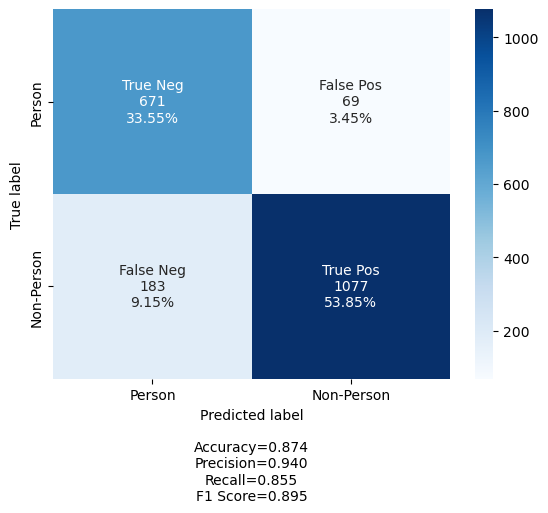

In [ ]:
y_true = temp_test_data['Email Type']
y_pred = temp_test_data['pred_email_type']
evaluation_results = Evaluate().compute_evaluation_metrics(y_true, y_pred)

#### Save the output file in s3

In [ ]:
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
object_name = f"data/email-type/output/{model}/email_type_prediction_results_{timestamp}"
# Create the file name as per the task: name-parse, email-signature
file_name = f"email_type_prediction_results_{timestamp}.csv"
upload_dataframe_to_s3(bucket_name, object_name, file_name, temp_test_data)

# Save the file locally to quickly check the data
# temp_test_data.to_csv(file_name, index=True)

#### Save the results summary in s3

In [ ]:
input_data_uri = r's3://{0}/{1}'.format(bucket_name, s3_file_key)
output_data_uri = r's3://{0}/{1}/{2}'.format(bucket_name, object_name, file_name)

results_summary = {
    "input_data": input_data_uri,
    "model_id": model_id,
    "model_version": model_version,
    "prompt_version": prompt_version,
    "system_prompt":system_prompt,
    "instruction_sample": instructions[0],
    "output_data": output_data_uri,
    "evaluation_results": evaluation_results
}
upload_data_to_s3(results_summary, bucket_name, object_name)

Data upload successfull s3_uri:  s3://sagemaker-sigparser-caylent-mlops/data/email-type/output/Llama 2 7B Chat/email_type_prediction_results_2024-03-26_00-58-53/results_summary.json


True

In [ ]:
evaluation_results

{'accuracy': 0.874,
 'precision': 0.9397905759162304,
 'recall': 0.8547619047619047,
 'f1_score': 0.8952618453865338}